# Exploration of new techniques to build a connectome
The aim of this notebook is to test various ideas to try to avoid the construction of a differential network on pearson correlations.

Contrary to the "exploration" notebook, we here focus on a reduced dataset made of meta-organs.

## Data processing

In [1]:
import pandas as pd
import numpy as np
import random
import warnings

from scipy.linalg import eigvalsh
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from utilsData import *
from utilsStats import build_correlation_matrix, build_graph_from_correlation_df, build_significance_matrix_for_diff, is_connected
from utilsVisual import plot_correlogram, plot_connectome
from utilsClustering import custom_spectral_clustering_on_similarity_matrix, compute_frobenius_similarity, compute_cosine_similarity, compute_spectral_distance, compute_deltaCon_distance, compute_cut_distance, compute_mahalanobis_similarity
from utilsExploration import *

random.seed(2003)
np.random.seed(2003) 

In [2]:
patients_data = load_data_from_patients_folder("../Data/PATIENTS-IDIOPATHIQUES", resample_max_length=None)
patients_data = create_meta_organs(patients_data, resample_max_length=5000)

controls_data = load_data_from_patients_folder("../Data/CONTROLES", resample_max_length=None)
controls_data = create_meta_organs(controls_data, resample_max_length=5000)

patients = patients_data.keys()
controls = controls_data.keys()

patients_list = list(patients)
controls_list = list(controls)

names = patients_data[list(patients)[0]].loc["name"]
names = names.to_numpy()

print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")

Loaded data for 22-53 patients.


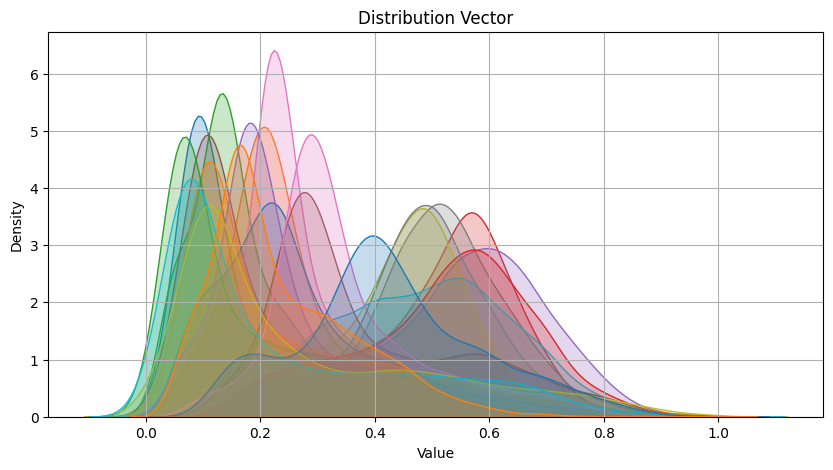

In [3]:
plot_distribution_vector([np.array(patients_data[item][10]["SUV"])/max(patients_data[item][10]["SUV"]) for item in patients_list])

In [3]:
controls_data, other_controls_data = remove_last_n_elements_and_slice(controls_data, 8)
controls = controls_data.keys()
other_controls = other_controls_data.keys()
other_controls_list = list(other_controls)
controls_list = list(controls)
organ_names_dict = patients_data[patients_list[0]].loc["name"].to_dict()

## Let's build some individuals connectomes

In [4]:
import numpy as np
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import cdist

def energy_distance(samples_p, samples_q):
    """
    Compute the Energy Distance between two distributions.

    Args:
        samples_p (np.ndarray or list): Samples from distribution P.
        samples_q (np.ndarray or list): Samples from distribution Q.

    Returns:
        float: Energy Distance.
    """
    # Ensure input is a NumPy array
    samples_p = np.asarray(samples_p).reshape(-1, 1)
    samples_q = np.asarray(samples_q).reshape(-1, 1)

    # Compute pairwise distances
    term1 = np.mean(cdist(samples_p, samples_q, metric='euclidean'))
    term2 = np.mean(cdist(samples_p, samples_p, metric='euclidean'))
    term3 = np.mean(cdist(samples_q, samples_q, metric='euclidean'))

    return 2 * term1 - term2 - term3

def kl_divergence_histogram(samples_p, samples_q, num_bins=100):
    """
    Compute the empirical KL divergence between two distributions using histogram-based probability densities.

    Args:
        samples_p (np.ndarray): Sampled values from distribution P.
        samples_q (np.ndarray): Sampled values from distribution Q.
        num_bins (int): Number of histogram bins.

    Returns:
        float: Symmetric KL divergence (D_KL(P || Q) + D_KL(Q || P)).
    """
    min_val, max_val = min(np.min(samples_p), np.min(samples_q)), max(np.max(samples_p), np.max(samples_q))
    bins = np.linspace(min_val, max_val, num_bins)

    p_hist, _ = np.histogram(samples_p, bins=bins, density=True)
    q_hist, _ = np.histogram(samples_q, bins=bins, density=True)

    p_hist += 1e-10  # Avoid division by zero
    q_hist += 1e-10

    kl_pq = np.sum(p_hist * np.log(p_hist / q_hist)) * (max_val - min_val) / num_bins
    kl_qp = np.sum(q_hist * np.log(q_hist / p_hist)) * (max_val - min_val) / num_bins

    return kl_pq + kl_qp  # Symmetric KL divergence


def wasserstein_approximation(samples_p, samples_q, method="quantile", num_bins=100, num_quantiles=100):
    """
    Compute an approximated Wasserstein distance between two large distributions.
    
    Args:
        samples_p (np.ndarray): Sampled values from distribution P.
        samples_q (np.ndarray): Sampled values from distribution Q.
        method (str): Approximation method ("histogram" or "quantile").
        num_bins (int): Number of bins for histogram approximation.
        num_quantiles (int): Number of quantiles for quantile approximation.
    
    Returns:
        float: Approximated Wasserstein distance.
    """
    if method == "histogram":
        # Define a common bin range
        min_val = min(np.min(samples_p), np.min(samples_q))
        max_val = max(np.max(samples_p), np.max(samples_q))
        bins = np.linspace(min_val, max_val, num_bins)

        # Compute histogram bin centers and densities
        p_hist, _ = np.histogram(samples_p, bins=bins, density=True)
        q_hist, _ = np.histogram(samples_q, bins=bins, density=True)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Compute Wasserstein distance using histograms
        dist = wasserstein_distance(bin_centers, bin_centers, p_hist, q_hist)

    elif method == "quantile":
        # Generate quantiles for both distributions
        quantiles = np.linspace(0, 1, num_quantiles)
        p_quantiles = np.quantile(samples_p, quantiles)
        q_quantiles = np.quantile(samples_q, quantiles)

        # Wasserstein distance between quantile approximations
        dist = np.mean(np.abs(p_quantiles - q_quantiles))

    else:
        raise ValueError("Unsupported approximation method. Choose 'histogram' or 'quantile'.")

    return dist


def bhattacharyya_quantile(samples_p, samples_q, num_quantiles=100, epsilon=1e-10):
    """
    Compute the Bhattacharyya distance between two distributions using quantile approximation.

    Args:
        samples_p (np.ndarray): Sampled values from distribution P.
        samples_q (np.ndarray): Sampled values from distribution Q.
        num_quantiles (int): Number of quantiles to use for approximation.
        epsilon (float): small value to prevent division by zero, and log(0).

    Returns:
        float: Bhattacharyya distance.
    """
    # Compute quantiles for both distributions
    quantiles = np.linspace(0, 1, num_quantiles)
    p_quantiles = np.quantile(samples_p, quantiles)
    q_quantiles = np.quantile(samples_q, quantiles)

    # Compute probability densities from quantiles (finite difference approximation)
    p_densities = np.gradient(p_quantiles)
    q_densities = np.gradient(q_quantiles)

    # Normalize densities to sum to 1, with handling for zero sums
    p_sum = np.sum(p_densities)
    q_sum = np.sum(q_densities)

    if p_sum > epsilon:
        p_densities /= p_sum
    else:
        p_densities = np.ones_like(p_densities) / len(p_densities) #If all zero, make uniform distribution.

    if q_sum > epsilon:
        q_densities /= q_sum
    else:
        q_densities = np.ones_like(q_densities) / len(q_densities) #If all zero, make uniform distribution.

    # Compute Bhattacharyya coefficient (sum of square-rooted probability densities)
    bc = np.sum(np.sqrt(p_densities * q_densities))

    # Convert to Bhattacharyya distance
    return -np.log(bc + epsilon)  # Avoid log(0)

def bhattacharyya(i, j):
    samples_p, samples_q = organs[organ_names[i]], organs[organ_names[j]]
    x_min, x_max = min(np.min(samples_p), np.min(samples_q)), max(np.max(samples_p), np.max(samples_q))
    bins = np.linspace(x_min, x_max, 100)

    p_hist, _ = np.histogram(samples_p, bins=bins, density=True)
    q_hist, _ = np.histogram(samples_q, bins=bins, density=True)

    bc = np.sum(np.sqrt(p_hist * q_hist)) * (x_max - x_min) / 100
    return -np.log(bc + 1e-10)


def build_adjacency_matrix2(organs, metric="kl_divergence", threshold=None, k=None, covariance_matrix=None, cov_sensitivity=1):
    """
    Build the adjacency matrix for a graph of organs based on empirical distributions.

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are sample vectors (np.ndarray).
        metric (str): Distance metric to use ("kl_divergence", "wasserstein", "jensen_shannon", "euclidean", "bhattacharyya").
        threshold (float, optional): Max allowed distance to connect nodes (for threshold-based graphs).
        k (int, optional): Number of nearest neighbors to connect each node (for k-NN graphs).
        covariance_matrix (np.ndarray, optional): Covariance matrix between organ variables.
        confidence (np.ndarray, optional): Vector of Shapiro p-values to check assumptions.

    Returns:
        np.ndarray: Adjusted adjacency matrix (symmetric).
        list: Ordered list of organ names corresponding to matrix indices.
    """
    organ_names = list(organs.keys())
    num_organs = len(organ_names)
    distance_matrix = np.zeros((num_organs, num_organs))

    # Compute distance matrix
    if metric == "kl_divergence":
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = kl_divergence_histogram(organs[organ_names[i]], organs[organ_names[j]])
                distance_matrix[i, j] = distance_matrix[j, i] = dist
    elif metric == "energy":
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = energy_distance(organs[organ_names[i]], organs[organ_names[j]])
                distance_matrix[i, j] = distance_matrix[j, i] = dist
    elif metric == "wasserstein":
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = wasserstein_approximation(organs[organ_names[i]], organs[organ_names[j]])
                distance_matrix[i, j] = distance_matrix[j, i] = dist

    elif metric == "jensen_shannon":
        def js_divergence(i, j):
            samples_p, samples_q = organs[organ_names[i]], organs[organ_names[j]]
            min_val, max_val = min(np.min(samples_p), np.min(samples_q)), max(np.max(samples_p), np.max(samples_q))
            bins = np.linspace(min_val, max_val, 100)

            p_hist, _ = np.histogram(samples_p, bins=bins, density=True)
            q_hist, _ = np.histogram(samples_q, bins=bins, density=True)

            return jensenshannon(p_hist, q_hist)

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = js_divergence(i, j)
                distance_matrix[i, j] = distance_matrix[j, i] = dist

    elif metric == "euclidean" or metric == "euclidean-on-log":
        organ_vectors = resample_vectors(organs)
        for i in range(len(organ_vectors)):
            for j in range(i + 1, len(organ_vectors)):
                dist = np.linalg.norm(organ_vectors[i] - organ_vectors[j])
                distance_matrix[i, j] = distance_matrix[j, i] = dist

    elif metric == "bhattacharyya":
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = bhattacharyya_quantile(organs[organ_names[i]], organs[organ_names[j]])
                distance_matrix[i, j] = distance_matrix[j, i] = dist

    else:
        raise ValueError("Unsupported metric. Choose 'kl_divergence', 'energy', 'wasserstein', 'jensen_shannon', 'euclidean', or 'bhattacharyya'.")

    # Adjust distance matrix with mutual information from covariance_matrix
    if covariance_matrix is not None:
        sigma = np.sqrt(np.diag(covariance_matrix))
        corr_matrix = covariance_matrix / np.outer(sigma, sigma)
        np.fill_diagonal(corr_matrix, 1.0)

        with np.errstate(divide='ignore', invalid='ignore'):
            mi_matrix = -0.5 * np.log(1 - np.square(corr_matrix))
        mi_matrix = np.nan_to_num(mi_matrix, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(mi_matrix, 0)

        mi_max = np.max(mi_matrix)
        if mi_max > 0:
            mi_matrix /= mi_max
        distance_matrix *= (1 - cov_sensitivity * mi_matrix)

    # Build adjacency matrix
    adjacency_matrix = np.zeros((num_organs, num_organs))

    if threshold is not None:
        if threshold != 0:
            adjacency_matrix[distance_matrix < threshold] = 1
        else:
            adjacency_matrix = np.exp(-distance_matrix)

    elif k is not None:
        for i in range(num_organs):
            nearest_indices = np.argsort(distance_matrix[i])[1:k+1]
            adjacency_matrix[i, nearest_indices] = adjacency_matrix[nearest_indices, i] = 1

    np.fill_diagonal(adjacency_matrix, 0)

    return adjacency_matrix, organ_names


In [5]:
import concurrent.futures

def process_patient(patient, data, connectomes_dict, cov_sensitivity):
    organs_raw = data[patient].loc["SUV"].to_numpy()
    #organs = build_organ_dict(organs_raw)
    cov, _ = compute_pairwise_covariance(organs_raw)
    adj_matrix = build_adjacency_matrix2(data[patient].loc["SUV"], metric="bhattacharyya", threshold=0, covariance_matrix=cov, cov_sensitivity=cov_sensitivity)[0]
    adj_matrix2 = build_adjacency_matrix2(data[patient].loc["SUV"], metric="kl_divergence", threshold=0, covariance_matrix=cov, cov_sensitivity=cov_sensitivity)[0]
    adj_matrix4 = build_adjacency_matrix2(data[patient].loc["SUV"], metric="wasserstein", threshold=0, covariance_matrix=cov, cov_sensitivity=cov_sensitivity)[0]
    adj_matrix5 = build_adjacency_matrix2(data[patient].loc["SUV"], metric="energy", threshold=0, covariance_matrix=cov, cov_sensitivity=cov_sensitivity)[0]

    connectomes_dict[patient] = {
        'bhattacharyya': adj_matrix,
        'kl_divergence': adj_matrix2,
        'wasserstein': adj_matrix4,
        'energy': adj_matrix5,
    }
    print(f"{'Patient' if connectomes_dict is patients_connectomes else ('Control' if connectomes_dict is controls_connectomes else 'Other control')} {patient} completed")
    del cov, organs_raw

def process_group(patients_list, data, connectomes_dict, cov_sensitivity):
    for patient in patients_list:
        process_patient(patient, data, connectomes_dict, cov_sensitivity)

def process_groups_concurrently(patients_list, patients_data, patients_connectomes,
                                controls_list, controls_data, controls_connectomes,
                                other_controls_list, other_controls_data, other_controls_connectomes,
                                cov_sensitivity):
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        futures = [
            executor.submit(process_group, patients_list, patients_data, patients_connectomes, cov_sensitivity),
            executor.submit(process_group, controls_list, controls_data, controls_connectomes, cov_sensitivity),
            executor.submit(process_group, other_controls_list, other_controls_data, other_controls_connectomes, cov_sensitivity)
        ]
        concurrent.futures.wait(futures)

# Example usage (assuming patients_list, controls_list, other_controls_list, patients_data, controls_data, other_controls_data are defined):
patients_connectomes = {}
controls_connectomes = {}
other_controls_connectomes = {}
cov_sensitivity = 0.75

process_groups_concurrently(patients_list, patients_data, patients_connectomes,
                            controls_list, controls_data, controls_connectomes,
                            other_controls_list, other_controls_data, other_controls_connectomes,
                            cov_sensitivity)

Other control 19610409 completed
Patient 19640625 completed
Control 19731011 completed
Other control 19890525 completed
Patient 19610703 completed
Control 19690212 completed
Other control 19600208 completed
Patient 19690510 completed
Control 19630627 completed
Other control 19840407 completed
Patient 19631101 completed
Control 19831126 completed
Other control 19611129 completed
Patient 19820922 completed
Control 19770210 completed
Other control 19580502 completed
Patient 19710705 completed
Control 19601119 completed
Other control 19590713 completed
Patient 19700303 completed
Control 19680305 completed
Other control 19870722 completed
Patient 19701209 completed
Control 19700302 completed
Patient 19660525 completed
Control 19580928 completed
Patient 19711209 completed
Control 19660215 completed
Patient 19720329 completed
Control 19611102 completed
Patient 19710525 completed
Control 19581128 completed
Patient 19910226 completed
Control 19810919 completed
Patient 19731004 completed
Control

Patient 0


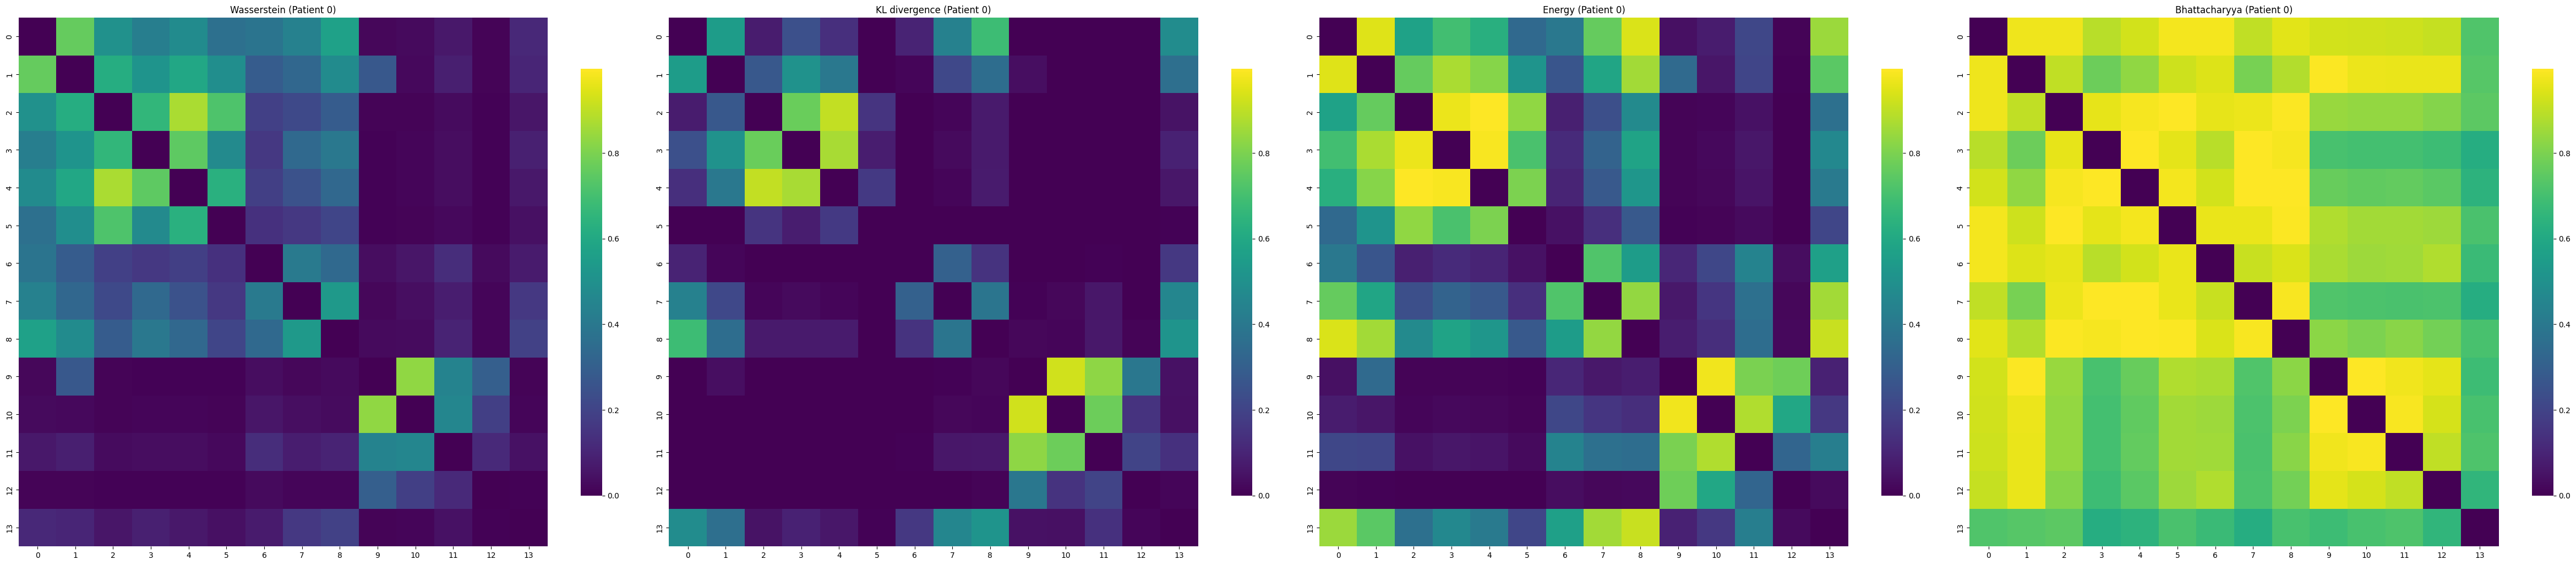

Control 0


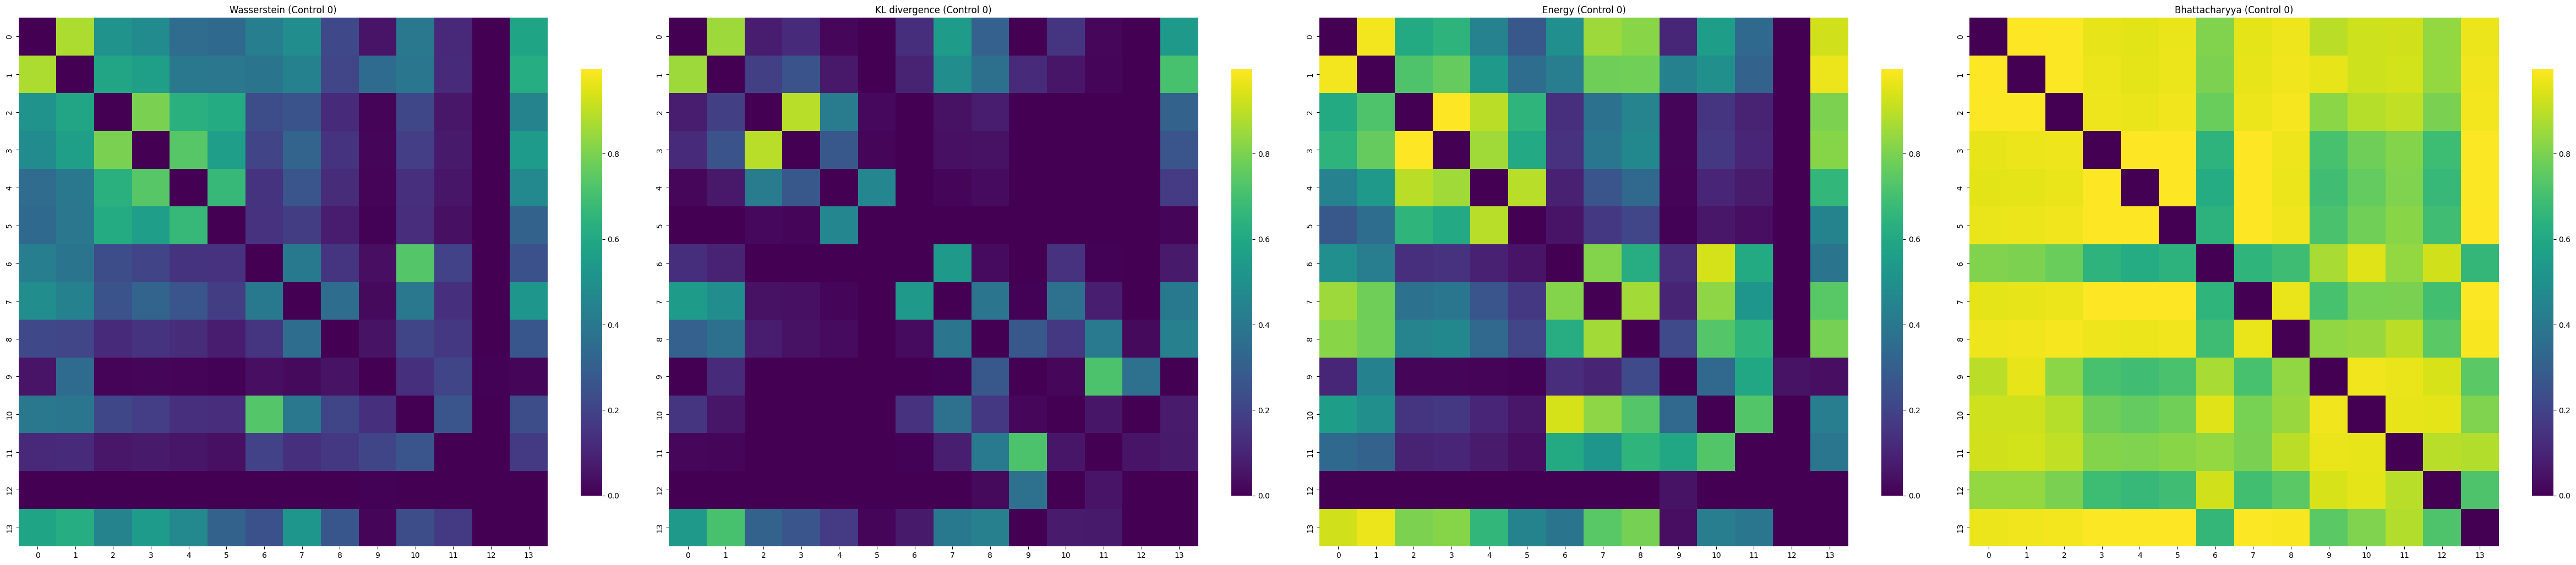

In [6]:
print("Patient 0")
#print_adjacency_matrices(patients_connectomes[patients_list[0]])
plot_correlogram(patients_connectomes[patients_list[0]]["wasserstein"], 
                 patients_connectomes[patients_list[0]]["kl_divergence"], 
                 patients_connectomes[patients_list[0]]["energy"], 
                 patients_connectomes[patients_list[0]]["bhattacharyya"],
                 titles=["Wasserstein (Patient 0)", "KL divergence (Patient 0)", "Energy (Patient 0)", "Bhattacharyya (Patient 0)"])

print("Control 0")
#print_adjacency_matrices(patients_connectomes[patients_list[0]])
plot_correlogram(controls_connectomes[controls_list[0]]["wasserstein"], 
                 controls_connectomes[controls_list[0]]["kl_divergence"], 
                 controls_connectomes[controls_list[0]]["energy"], 
                 controls_connectomes[controls_list[0]]["bhattacharyya"],
                 titles=["Wasserstein (Control 0)", "KL divergence (Control 0)", "Energy (Control 0)", "Bhattacharyya (Control 0)"],)

In [7]:
from scipy.stats import f_oneway

# Assuming controls_connectomes, patients_connectomes, other_controls_connectomes are defined
# and build_adjacency_matrix2, energy_distance, kl_divergence_histogram, wasserstein_approximation,
# bhattacharyya_quantile, bhattacharyya, resample_vectors are defined elsewhere.

def compute_variance(connectomes_dict, metric):
    """Computes the variance of adjacency matrices for a given metric."""
    matrices = [patient_matrices[metric] for patient_matrices in connectomes_dict.values()]
    return np.var(matrices, axis=0)


def compute_between_group_variance(connectomes_dicts, metric):
    """Computes the variance between groups for a given metric using ANOVA."""
    group_matrices = []
    for connectomes_dict in connectomes_dicts:
        group_matrices.append(np.array([patient_matrices[metric].flatten() for patient_matrices in connectomes_dict.values()]))

    # Flatten the group matrices into lists of vectors
    group_vectors = [np.vstack(group_matrix) for group_matrix in group_matrices]

    num_organs = group_matrices[0][0].shape[1] if len(group_matrices[0][0].shape) > 1 else int(np.sqrt(group_matrices[0][0].shape[0]))

    for group in group_matrices:
        if int(np.sqrt(group[0].shape[0])) != num_organs:
            raise ValueError("Inconsistent matrix shapes across groups.")

    # Find minimum number of samples
    min_samples = min(group_vectors[k].shape[0] for k in range(len(group_vectors)))

    # Perform ANOVA for each coefficient in the adjacency matrix (excluding diagonal)
    f_values = np.zeros((num_organs, num_organs))
    p_values = np.zeros((num_organs, num_organs))

    for i in range(num_organs):
        for j in range(num_organs):
            if i != j:  # Exclude diagonal elements
                group_samples = [group_vectors[k][:min_samples, i * num_organs + j] for k in range(len(group_vectors))] #Truncate the group_samples.
                
                # Check for constant values and empty groups.
                if group_samples and all(np.all(group_samples[0] == x) for x in group_samples):
                    f_values[i, j] = np.nan  # Assign NaN if constant
                    p_values[i, j] = np.nan
                elif group_samples:
                    f_val, p_val = f_oneway(*group_samples)
                    f_values[i, j] = f_val
                    p_values[i, j] = p_val
                else:
                    f_values[i,j] = np.nan
                    p_values[i,j] = np.nan
            else:
                f_values[i,j] = np.nan
                p_values[i,j] = np.nan

    return f_values, p_values


def find_optimal_metric(patients_connectomes, controls_connectomes, other_controls_connectomes):
    """Finds the metric that minimizes intragroup variance and maximizes between-group variance."""
    metrics = ['bhattacharyya', 'kl_divergence', 'wasserstein', 'energy']

    intragroup_variances = {}
    between_group_f_values = {}
    between_group_p_values = {}

    if not patients_connectomes or not controls_connectomes or not other_controls_connectomes:
        raise ValueError("One or more connectomes dictionaries are empty.")

    for metric in metrics:
        intragroup_variances[metric] = {
            'patients': compute_variance(patients_connectomes, metric),
            'controls': compute_variance(controls_connectomes, metric),
            'other_controls': compute_variance(other_controls_connectomes, metric)
        }
        f_vals, p_vals = compute_between_group_variance(
            [patients_connectomes, controls_connectomes, other_controls_connectomes], metric
        )
        between_group_f_values[metric] = f_vals
        between_group_p_values[metric] = p_vals

    overall_intragroup_variance = {}
    overall_between_group_variance = {}
    overall_between_group_p_values = {}

    for metric in metrics:
        overall_intragroup_variance[metric] = np.mean([
            np.mean(intragroup_variances[metric][group])
            for group in ['patients', 'controls', 'other_controls']
        ])
        overall_between_group_variance[metric] = np.nanmean(between_group_f_values[metric]) #Use nanmean.
        overall_between_group_p_values[metric] = np.nanmean(between_group_p_values[metric])

    best_metric = None
    best_score = float('-inf')

    for metric in metrics:
        score = overall_between_group_variance[metric] - overall_intragroup_variance[metric]
        if score > best_score:
            best_score = score
            best_metric = metric

    return best_metric, overall_intragroup_variance, overall_between_group_variance, overall_between_group_p_values #return p_values.


# Example usage (assuming patients_connectomes, controls_connectomes, other_controls_connectomes are defined):
best_metric, intragroup_vars, between_group_vars, between_group_p_values = find_optimal_metric(patients_connectomes, controls_connectomes, other_controls_connectomes)
print(f"Best metric: {best_metric}")
print("Intragroup variances:", intragroup_vars)
print("Between-group variances:", between_group_vars)
print("Between-group p-values:", between_group_p_values)

Best metric: energy
Intragroup variances: {'bhattacharyya': np.float64(0.006193962228319576), 'kl_divergence': np.float64(0.02622965527803602), 'wasserstein': np.float64(0.0208337930482084), 'energy': np.float64(0.01612441720888895)}
Between-group variances: {'bhattacharyya': np.float64(1.2544973474710683), 'kl_divergence': np.float64(1.159114915683598), 'wasserstein': np.float64(1.3250816797077754), 'energy': np.float64(1.4142541577431516)}
Between-group p-values: {'bhattacharyya': np.float64(0.46446484950189165), 'kl_divergence': np.float64(0.44099668324092567), 'wasserstein': np.float64(0.40242331546012233), 'energy': np.float64(0.375182016851833)}


In [8]:
__METRIC__ = "energy"

In NCS:


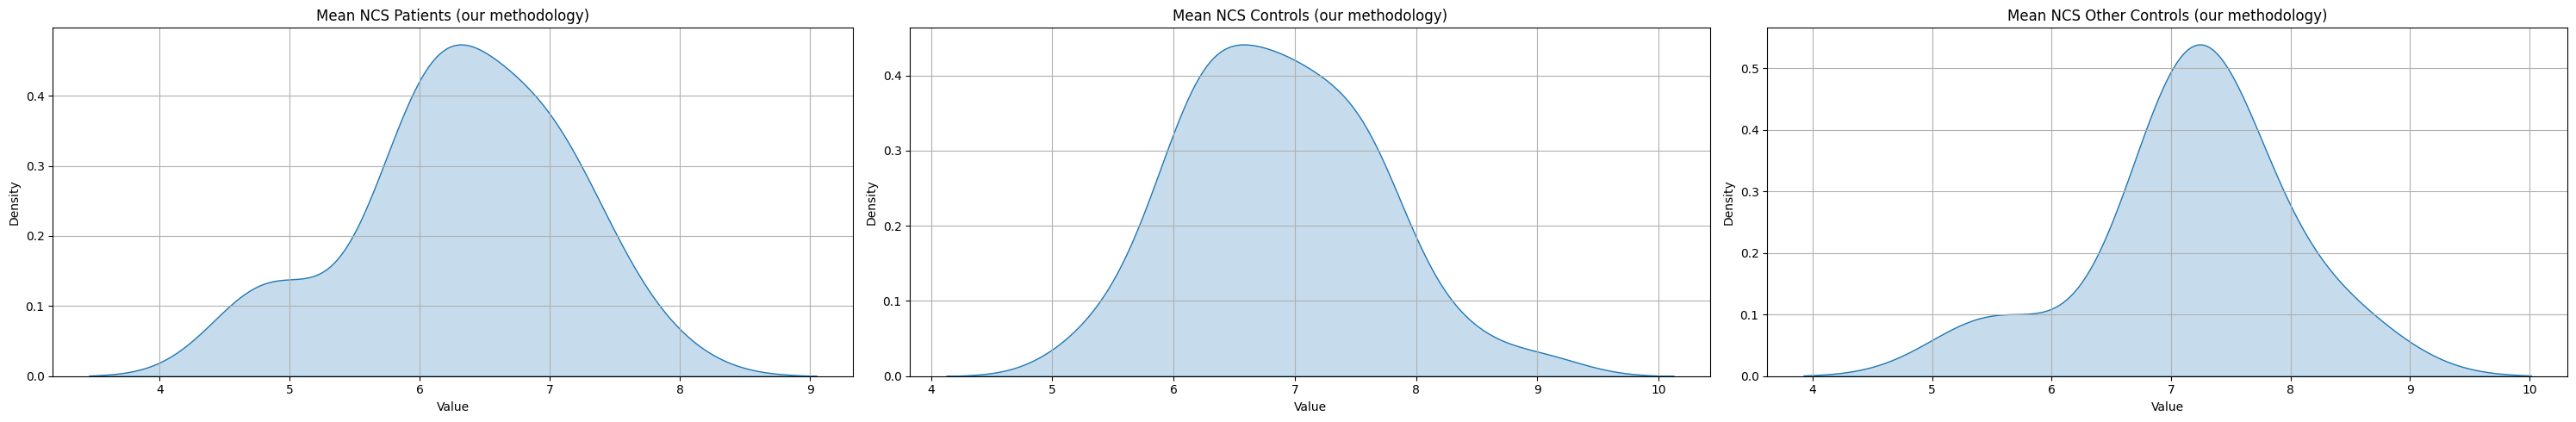

t-test: Patients vs controls
T-statistic: -2.6385284801838664
P-value: 0.011673119717833342
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Patients vs other controls
T-statistic: -2.532457227477586
P-value: 0.02587330024328102
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Controls vs other controls
T-statistic: -0.9584188396179818
P-value: 0.36150556959352975
No statistically significant difference found (p >= 0.05).


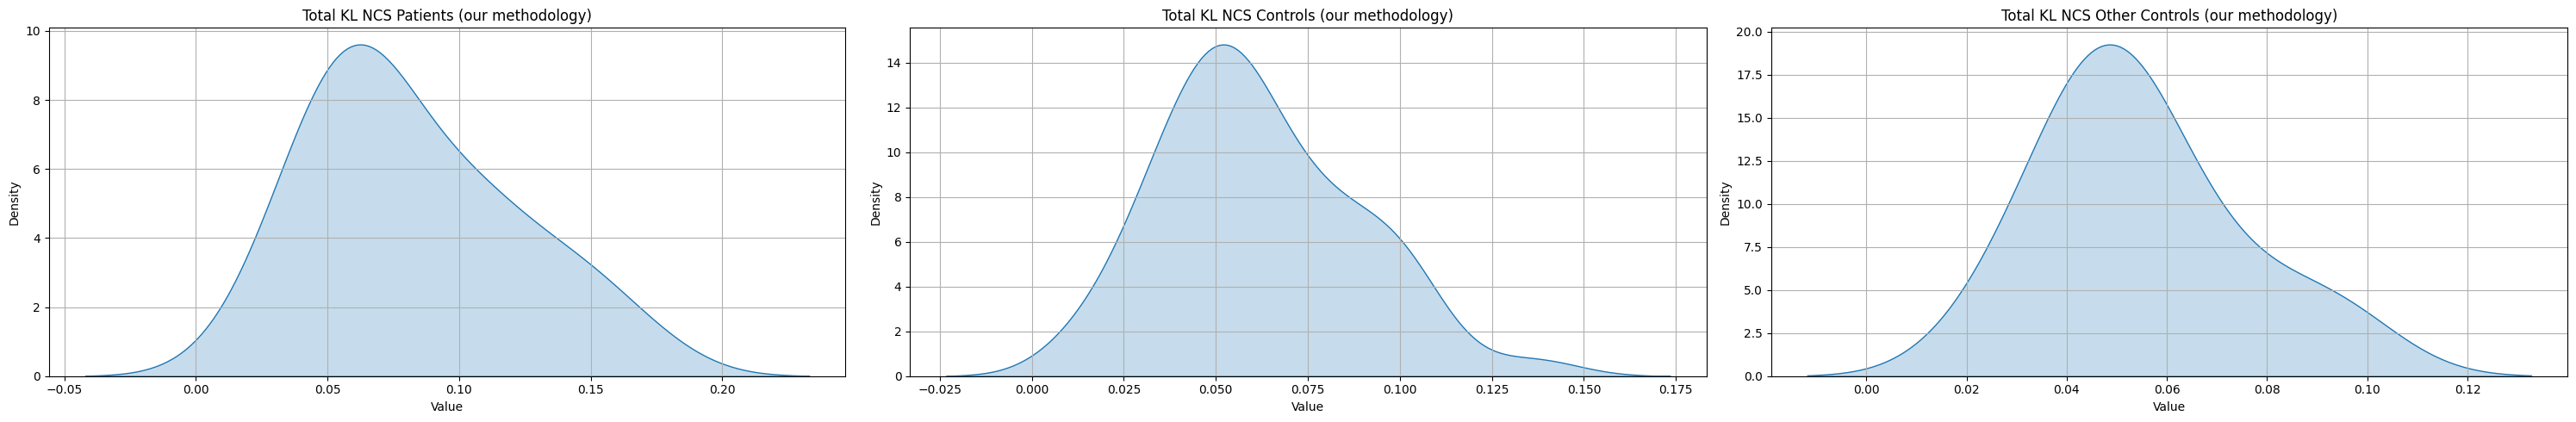

t-test: Patients vs controls
T-statistic: 2.2737142938546753
P-value: 0.030171934430356803
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Patients vs other controls
T-statistic: 2.556070585346058
P-value: 0.017199368097571017
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Controls vs other controls
T-statistic: 0.8614519290036419
P-value: 0.4061075645004769
No statistically significant difference found (p >= 0.05).


In [9]:
print("In NCS:")
individual_ncs_patients = [
    compute_ncs(patient_matrices[__METRIC__])
    for patient_matrices in patients_connectomes.values()
]

individual_ncs_controls = [
    compute_ncs(patient_matrices[__METRIC__])
    for patient_matrices in controls_connectomes.values()
]

individual_ncs_other_controls = [
    compute_ncs(patient_matrices[__METRIC__])
    for patient_matrices in other_controls_connectomes.values()
]

plot_density(np.mean(individual_ncs_patients, axis=1),np.mean(individual_ncs_controls, axis=1),np.mean(individual_ncs_other_controls, axis=1), titles=["Mean NCS Patients (our methodology)", "Mean NCS Controls (our methodology)", "Mean NCS Other Controls (our methodology)"])

print("t-test: Patients vs controls")
_ ,_ = do_t_test(np.mean(individual_ncs_patients, axis=1), np.mean(individual_ncs_controls, axis=1))
print("t-test: Patients vs other controls")
_ ,_ = do_t_test(np.mean(individual_ncs_patients, axis=1), np.mean(individual_ncs_other_controls, axis=1))
print("t-test: Controls vs other controls")
_ ,_ = do_t_test(np.mean(individual_ncs_controls, axis=1), np.mean(individual_ncs_other_controls, axis=1))

div_patients = [bhattacharyya_quantile(ncs_patient, np.mean(individual_ncs_controls, axis=0)) for ncs_patient in individual_ncs_patients]
div_controls = [bhattacharyya_quantile(ncs_patient, np.mean(individual_ncs_controls, axis=0)) for ncs_patient in individual_ncs_controls]
div_other_controls = [bhattacharyya_quantile(ncs_patient, np.mean(individual_ncs_controls, axis=0)) for ncs_patient in individual_ncs_other_controls]
plot_density(div_patients, div_controls, div_other_controls, titles=["Total KL NCS Patients (our methodology)", "Total KL NCS Controls (our methodology)", "Total KL NCS Other Controls (our methodology)"])
print("t-test: Patients vs controls")
_ ,_ = do_t_test(div_patients, div_controls)
print("t-test: Patients vs other controls")
_ ,_ = do_t_test(div_patients, div_other_controls)
print("t-test: Controls vs other controls")
_ ,_ = do_t_test(div_controls, div_other_controls)

In [10]:
reference_matrix = np.mean([
    patient_matrices[__METRIC__]
    for patient_matrices in controls_connectomes.values()
], axis=0)
distance_to_ref_patients = [
    (reference_matrix - patient_matrices[__METRIC__])
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls = [
    (reference_matrix - patient_matrices[__METRIC__])
    for patient_matrices in (controls_connectomes).values()]

distance_to_ref_other_controls = [
    (reference_matrix - patient_matrices[__METRIC__])
    for patient_matrices in (other_controls_connectomes).values()]

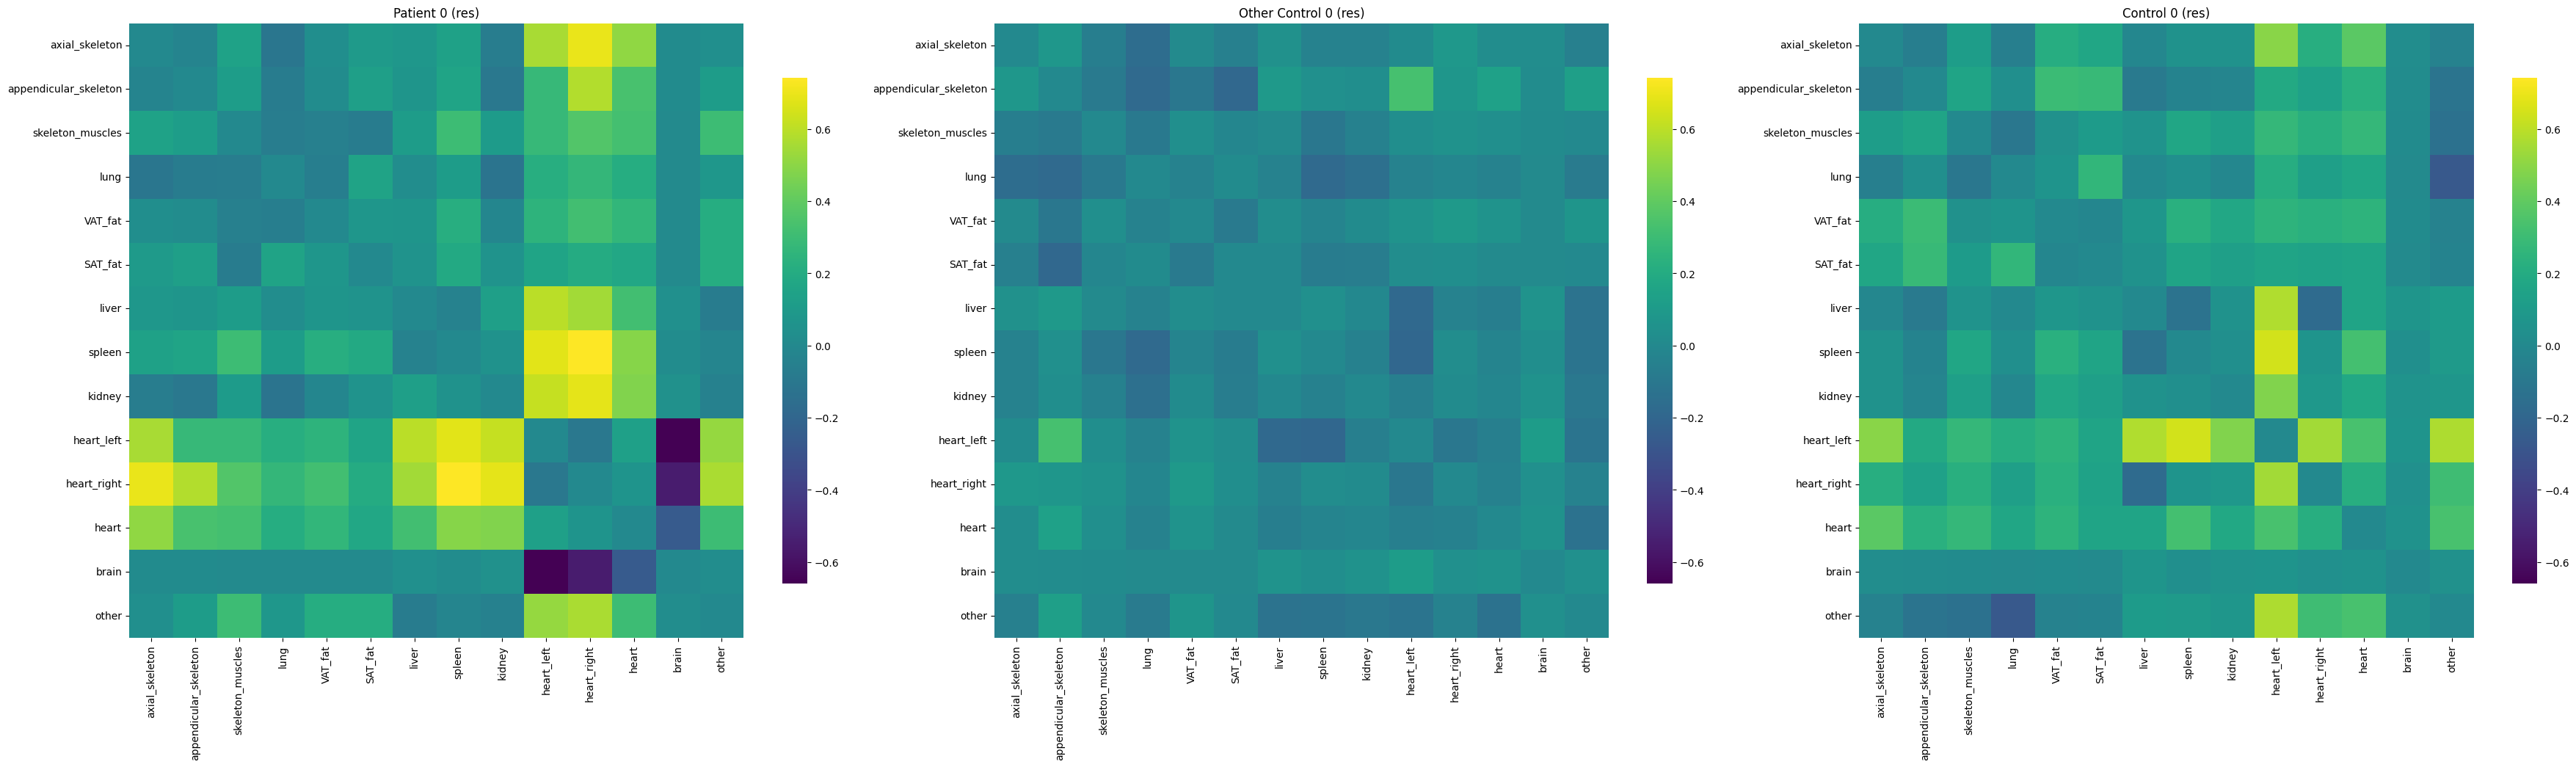

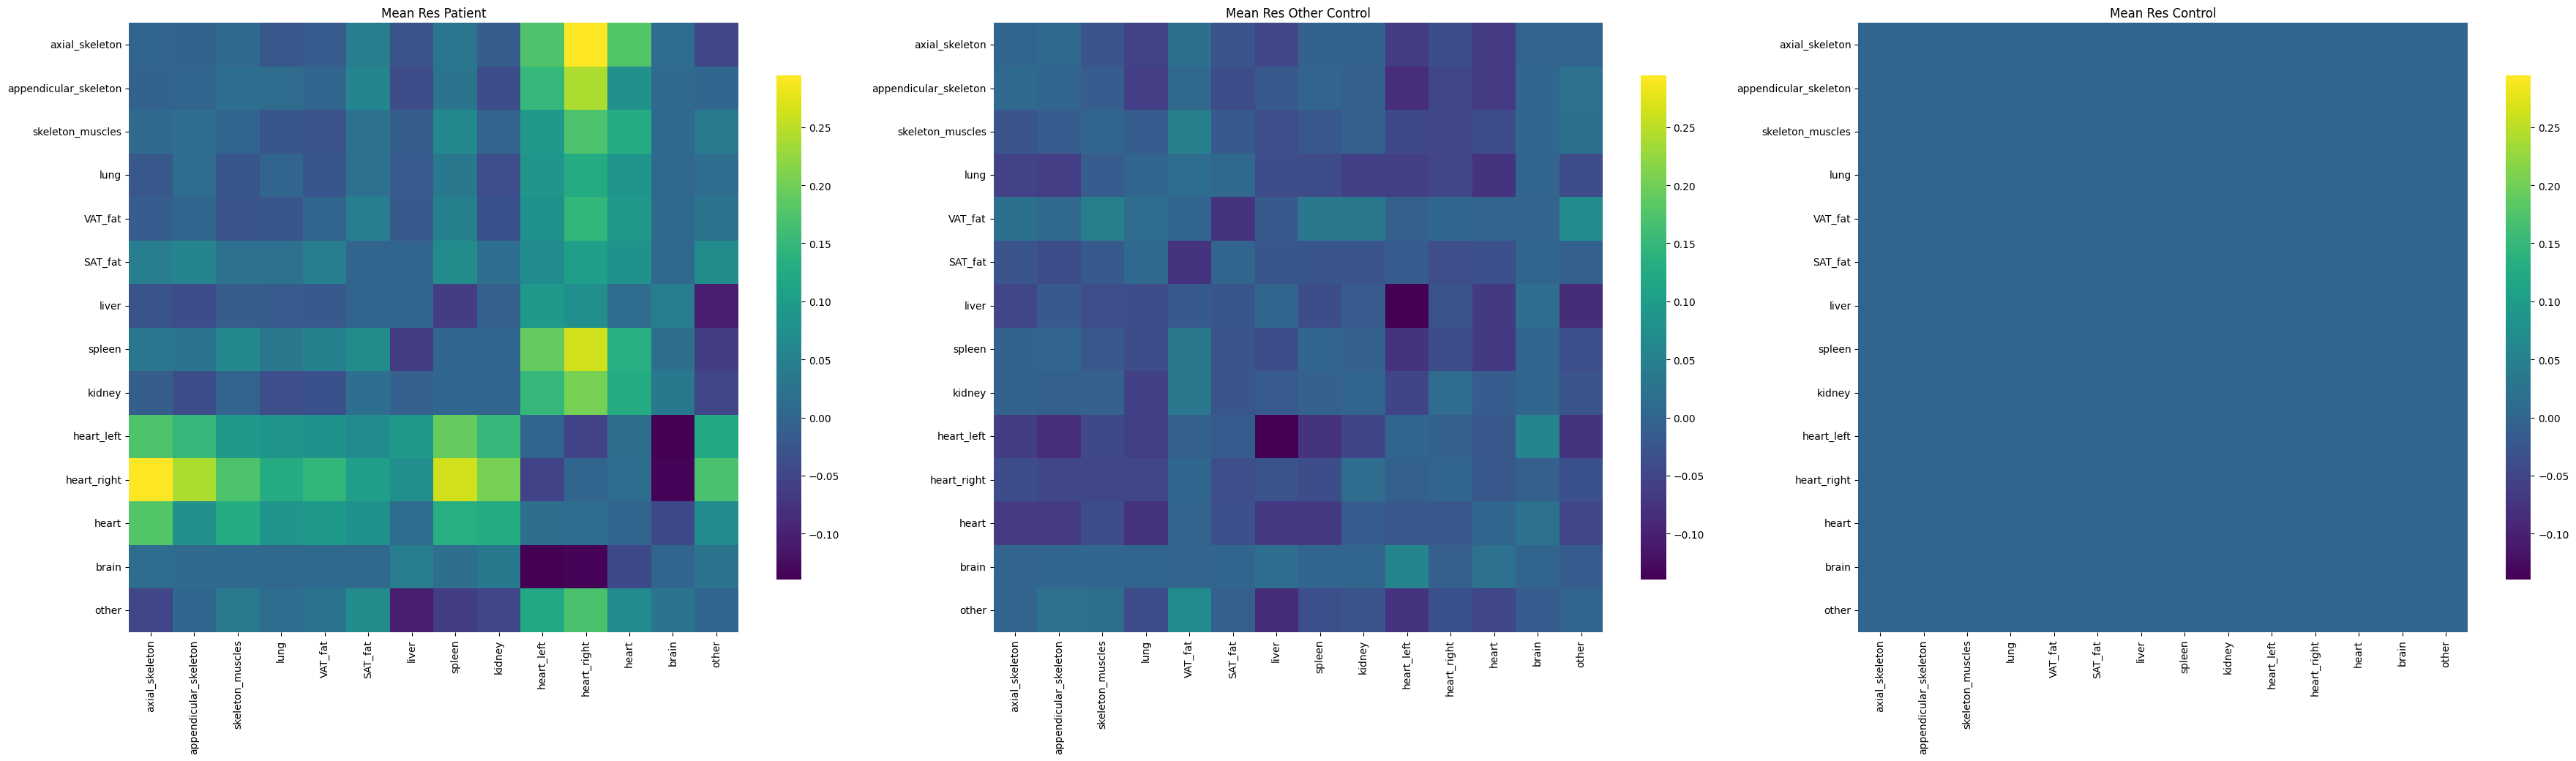

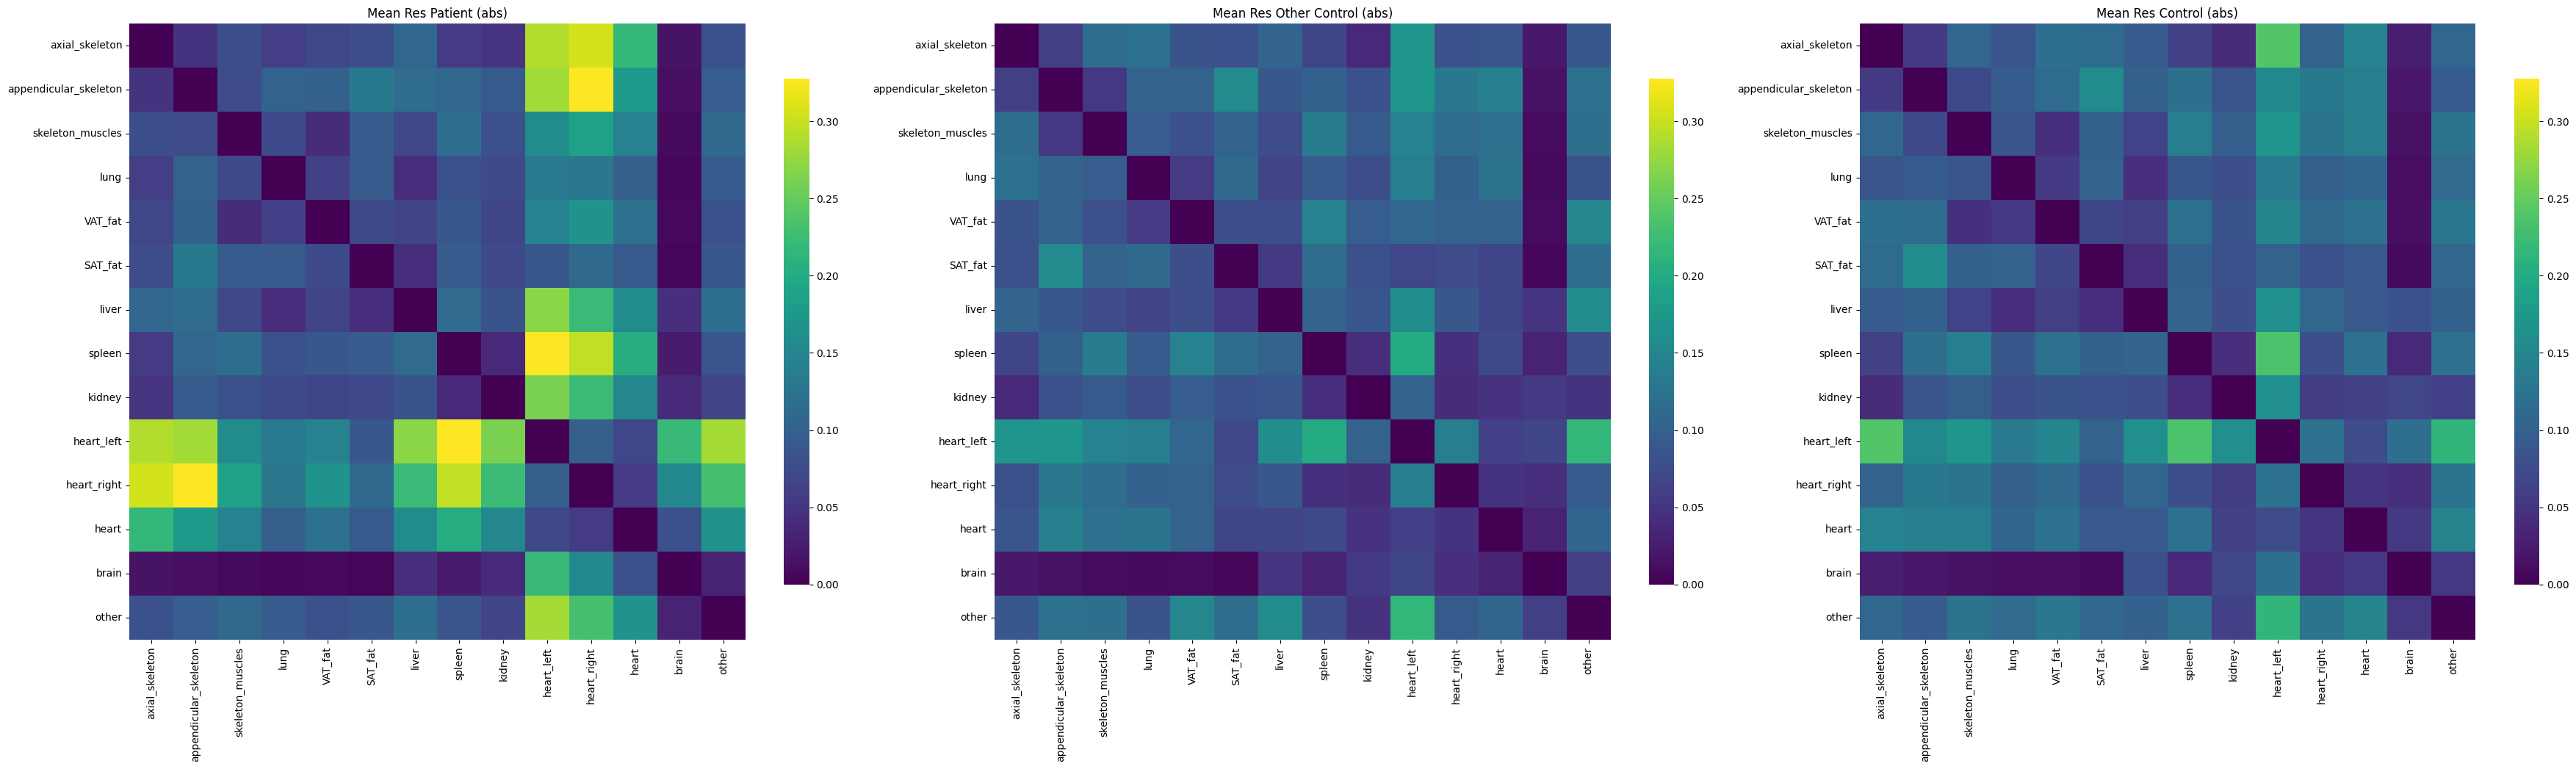

In [11]:
plot_correlogram(distance_to_ref_patients[0], distance_to_ref_other_controls[0], distance_to_ref_controls[0], titles=["Patient 0 (res)", "Other Control 0 (res)", "Control 0 (res)"], organ_names_dict=organ_names_dict)
plot_correlogram(np.mean(distance_to_ref_patients, axis=0), np.mean(distance_to_ref_other_controls, axis=0), np.mean(distance_to_ref_controls, axis=0), titles=["Mean Res Patient", "Mean Res Other Control", "Mean Res Control"],organ_names_dict=organ_names_dict)
plot_correlogram(np.mean(np.abs(distance_to_ref_patients), axis=0), np.mean(np.abs(distance_to_ref_other_controls), axis=0), np.mean(np.abs(distance_to_ref_controls), axis=0), titles=["Mean Res Patient (abs)", "Mean Res Other Control (abs)", "Mean Res Control (abs)"],organ_names_dict=organ_names_dict)

In [12]:
def compute_probability_matrix_kde(reference_matrices, test_matrix, bandwidth=0.2, epsilon=1e-6, exponent=0.2):
    """
    Compute the probability that each coefficient of the test matrix has been sampled 
    from the same distribution as the reference matrices using Kernel Density Estimation (KDE).

    Args:
        reference_matrices (list of np.ndarray): A list of squared, symmetric matrices 
                                                 representing the reference distribution.
        test_matrix (np.ndarray): A squared, symmetric test matrix.
        bandwidth (float): Bandwidth parameter for KDE (controls smoothness).
        epsilon (float): Small value to avoid division errors when variance is too low.

    Returns:
        np.ndarray: A matrix of 1 -p-values representing the probability that each coefficient 
                    in the test matrix (not) belongs to the same distribution as the reference set.
    """
    if len(reference_matrices) == 0:
        raise ValueError("Reference matrices list cannot be empty.")
    
    num_matrices = len(reference_matrices)
    shape = reference_matrices[0].shape

    if not all(mat.shape == shape for mat in reference_matrices):
        raise ValueError("All reference matrices must have the same shape.")
    
    if test_matrix.shape != shape:
        raise ValueError("Test matrix must have the same shape as reference matrices.")
    
    # Convert reference matrices into a 3D NumPy array (num_matrices, N, N)
    reference_array = np.array(reference_matrices)  # Shape: (num_matrices, N, N)

    # Initialize p-value matrix
    p_values_matrix = np.ones_like(test_matrix, dtype=np.float64)

    # Compute KDE-based p-values
    for i in range(shape[0]):
        for j in range(shape[1]):
            ref_values = reference_array[:, i, j]  # Extract values from reference matrices
            test_value = test_matrix[i, j]

            # Compute variance
            std_ref = np.std(ref_values, ddof=1)  # Sample standard deviation

            # If variance is too low, use direct comparison
            if std_ref < epsilon:
                p_values_matrix[i, j] = 1.0 if np.abs(test_value - np.mean(ref_values)) < epsilon else 0.0
                continue

            try:
                # Apply KDE with automatic bandwidth selection
                kde = gaussian_kde(ref_values, bw_method=bandwidth)
                p_value = np.mean(kde.integrate_box_1d(-np.inf, np.abs(test_value)))
            except np.linalg.LinAlgError:
                # If KDE fails, fall back to mean comparison
                p_value = 1.0 if np.abs(test_value - np.mean(ref_values)) < epsilon else 0.0

            p_values_matrix[i, j] = p_value

    return (1 - (p_values_matrix)**exponent) * np.sign(np.mean(reference_matrices, axis=0) - test_matrix)

def compute_percentile_difference(reference_matrices, test_matrix, epsilon=1e-6, exponent=1.5):
    if len(reference_matrices) == 0:
        raise ValueError("Reference matrices list cannot be empty.")
    
    reference_array = np.array(reference_matrices)  # This line is crucial
    num_matrices = len(reference_matrices)
    shape = reference_matrices[0].shape
    
    if not all(mat.shape == shape for mat in reference_matrices):
        raise ValueError("All reference matrices must have the same shape.")
    if test_matrix.shape != shape:
        raise ValueError("Test matrix must have the same shape as reference matrices.")
    
    # Convert reference matrices into a 3D NumPy array (num_matrices, N, N)
    reference_array = np.array(reference_matrices)
    
    difference_matrix = np.zeros_like(test_matrix, dtype=np.float64)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            ref_values = reference_array[:, i, j]
            test_value = test_matrix[i, j]
            
            # Handle near-zero variance case
            if np.std(ref_values) < epsilon:
                difference_matrix[i, j] = 0.0 if np.abs(test_value - np.mean(ref_values)) < epsilon else 1.0
                continue
            
            # Calculate percentile of test value in reference distribution
            percentile = stats.percentileofscore(ref_values, test_value) / 100
            
            # Convert to deviation from median (0.5)
            deviation = abs(percentile - 0.5)
            
            # Apply exponential transformation to emphasize extreme values
            # This will make values close to 0 or 1 exponentially larger
            exponential_score = deviation ** exponent
            
            # Keep the original sign
            sign = 1 if percentile >= 0.5 else -1
            
            # Scale to [-1, 1] range
            scaled_score = sign * exponential_score * 2
            
            difference_matrix[i, j] = scaled_score
            
    return difference_matrix

In [13]:
local_control_connectomes = [
    patient_matrices[__METRIC__]
    for patient_matrices in (controls_connectomes).values()]

distance_to_ref_patients_corrected = [
    compute_probability_matrix_kde(local_control_connectomes, patient_matrices[__METRIC__])
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls_corrected = [
    compute_probability_matrix_kde(local_control_connectomes, patient_matrices[__METRIC__])
    for patient_matrices in (controls_connectomes).values()]

distance_to_ref_other_controls_corrected = [
    compute_probability_matrix_kde(local_control_connectomes, patient_matrices[__METRIC__])
    for patient_matrices in (other_controls_connectomes).values()]

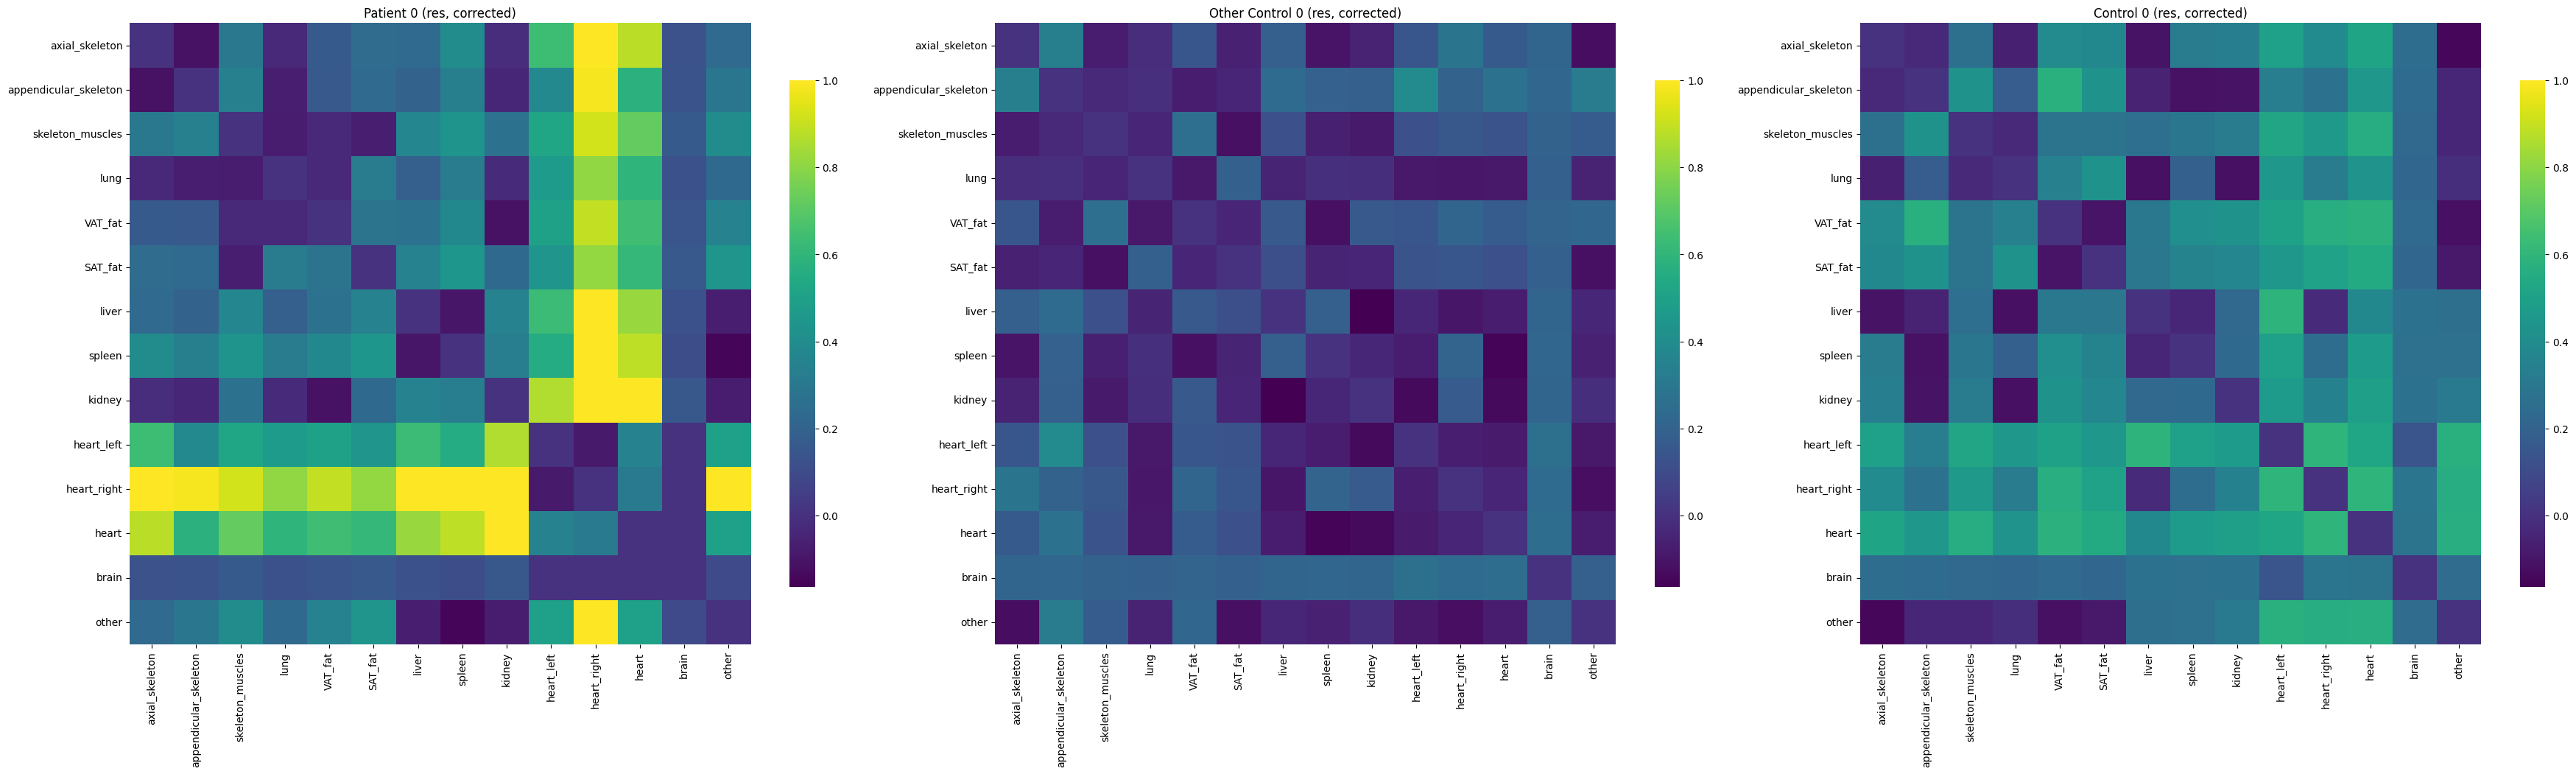

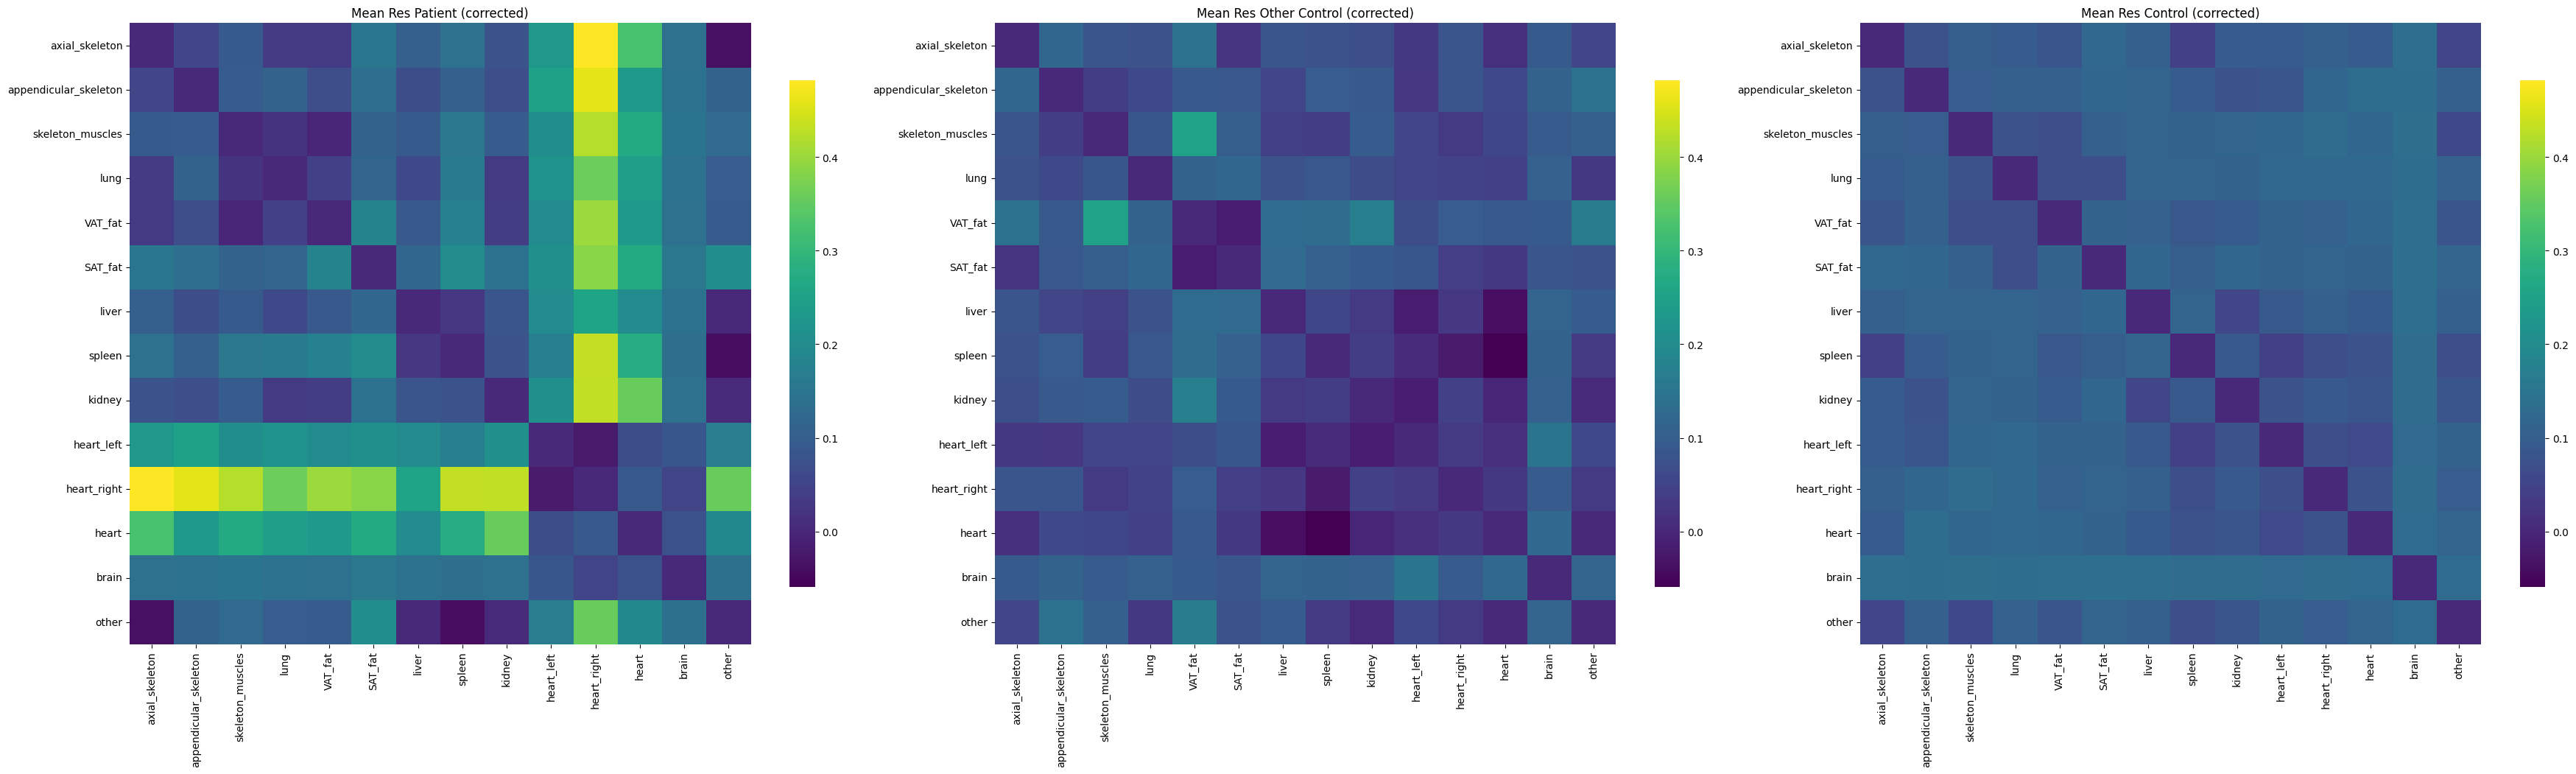

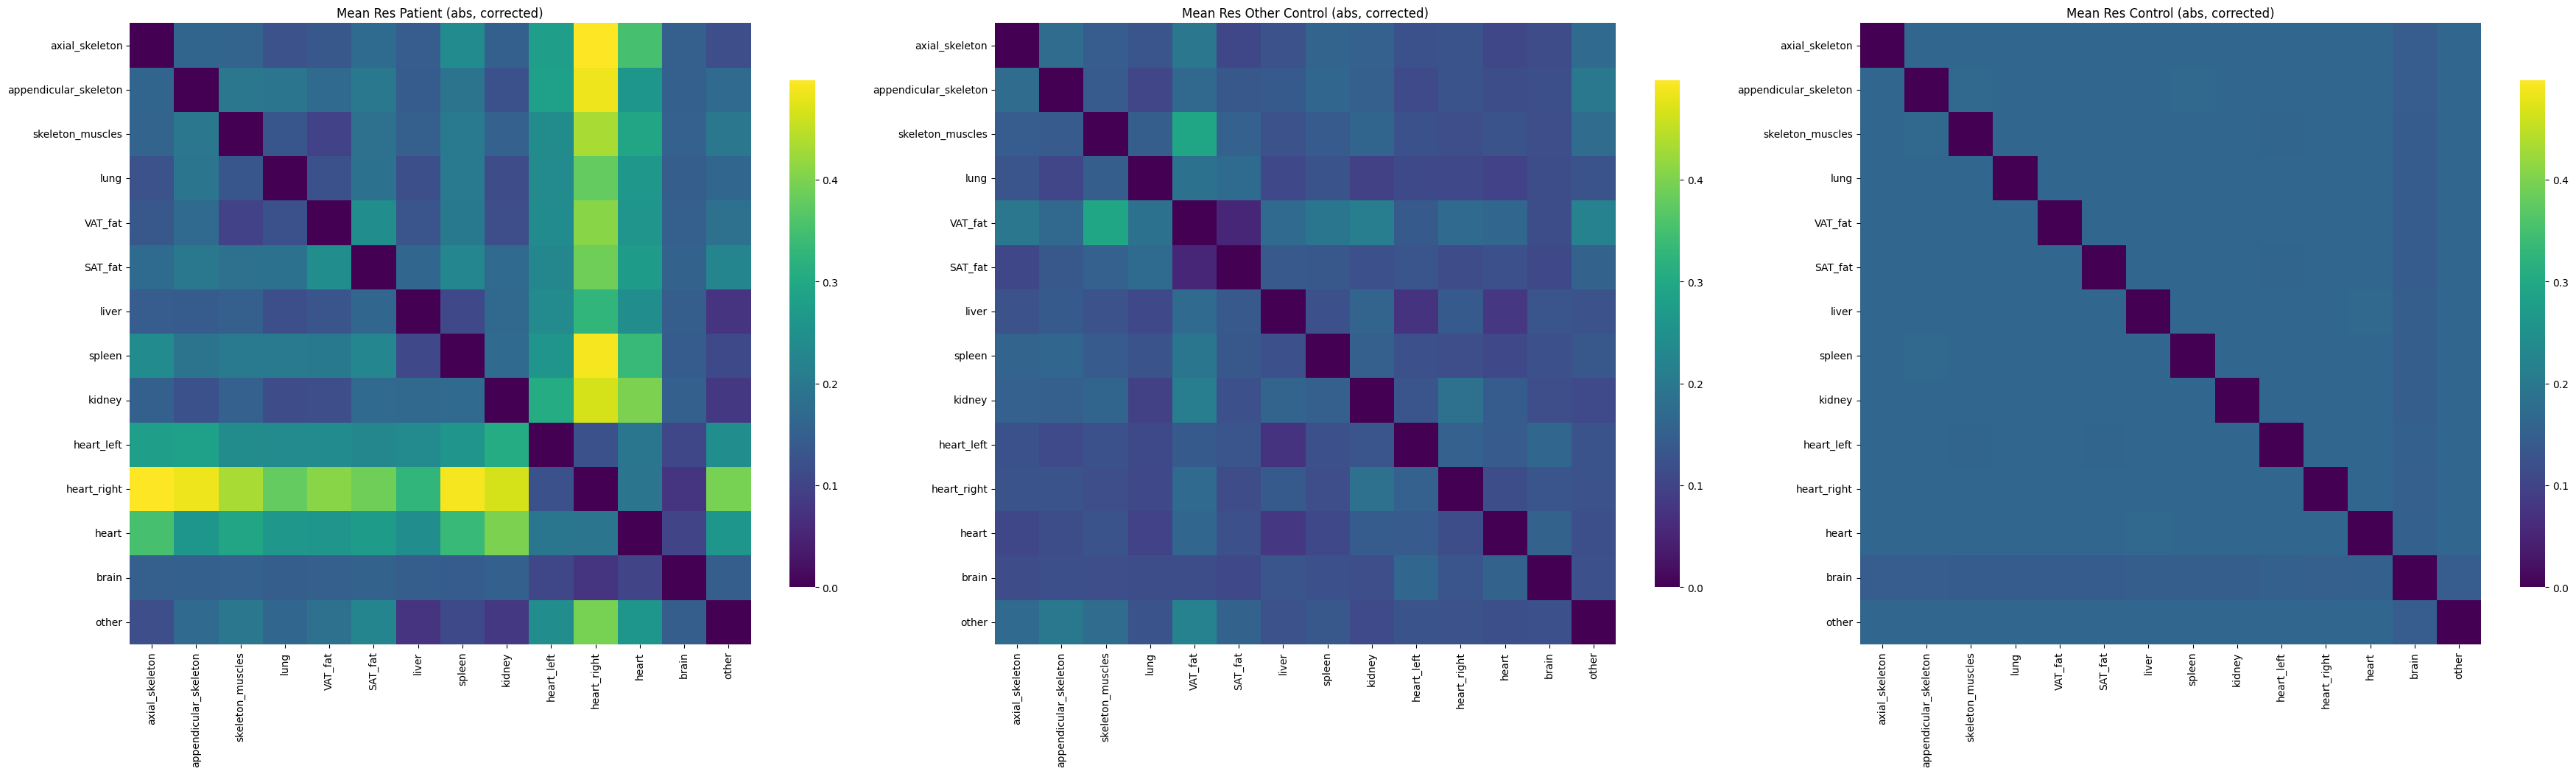

In [14]:
plot_correlogram(distance_to_ref_patients_corrected[0], distance_to_ref_other_controls_corrected[0], distance_to_ref_controls_corrected[0], titles=["Patient 0 (res, corrected)", "Other Control 0 (res, corrected)", "Control 0 (res, corrected)"], organ_names_dict=organ_names_dict)
plot_correlogram(np.mean(distance_to_ref_patients_corrected, axis=0), np.mean(distance_to_ref_other_controls_corrected, axis=0), np.mean(distance_to_ref_controls_corrected, axis=0), titles=["Mean Res Patient (corrected)", "Mean Res Other Control (corrected)", "Mean Res Control (corrected)"], organ_names_dict=organ_names_dict)
plot_correlogram(np.mean(np.abs(distance_to_ref_patients_corrected), axis=0), np.mean(np.abs(distance_to_ref_other_controls_corrected), axis=0), np.mean(np.abs(distance_to_ref_controls_corrected), axis=0), titles=["Mean Res Patient (abs, corrected)", "Mean Res Other Control (abs, corrected)", "Mean Res Control (abs, corrected)"], organ_names_dict=organ_names_dict)

**Normal residual networks**

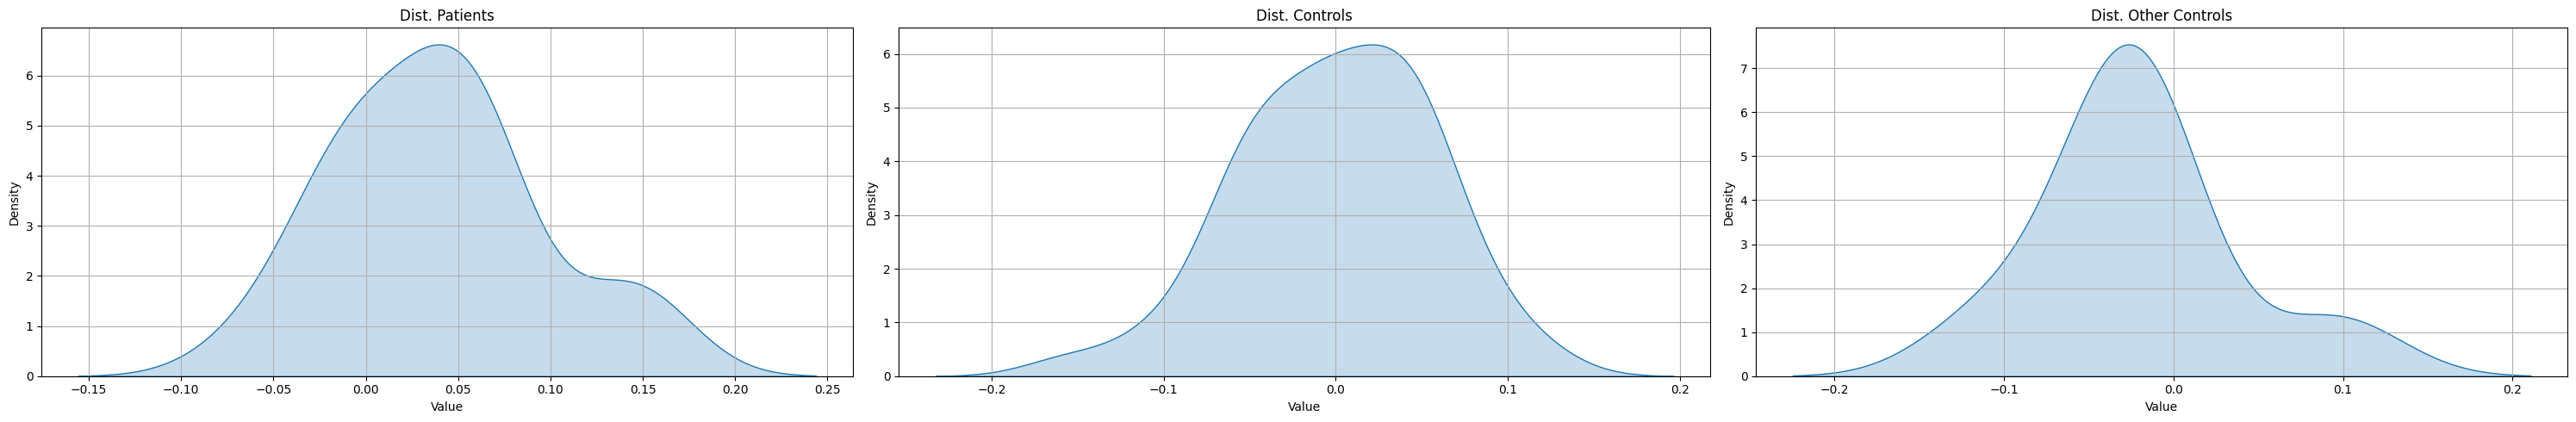

Patients vs controls
T-statistic: 2.6385284801838753
P-value: 0.011673119717833072
There is a statistically significant difference between distribA and distribB (p < 0.05).
Patients vs other controls
T-statistic: 2.532457227477591
P-value: 0.02587330024328078
There is a statistically significant difference between distribA and distribB (p < 0.05).
Controls vs other controls
T-statistic: 0.9584188396179806
P-value: 0.3615055695935302
No statistically significant difference found (p >= 0.05).


In [15]:
plot_density(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1),np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1),np.mean(np.mean(distance_to_ref_other_controls, axis=1), axis=1), titles=["Dist. Patients", "Dist. Controls", "Dist. Other Controls"])

print("Patients vs controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1))
print("Patients vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(distance_to_ref_other_controls, axis=1), axis=1))
print("Controls vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1), np.mean(np.mean(distance_to_ref_other_controls, axis=1), axis=1))


**Corrected residual networks**

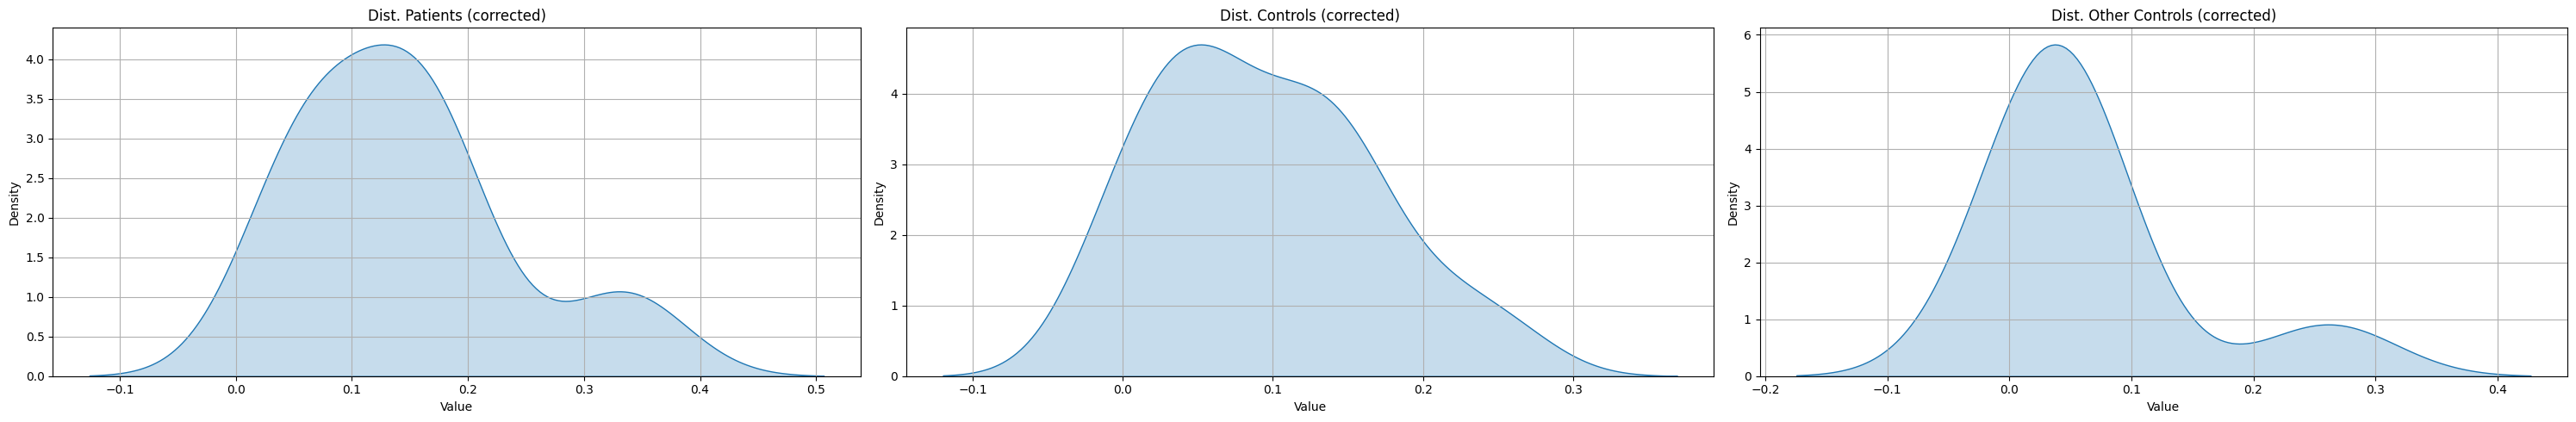

t-test: Patients vs controls
T-statistic: 2.278124660831279
P-value: 0.029104678628500812
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Patients vs other controls
T-statistic: 2.3089915908145455
P-value: 0.0368574884570494
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Controls vs other controls
T-statistic: 0.9661692222160544
P-value: 0.359112516697753
No statistically significant difference found (p >= 0.05).
In absolute value:


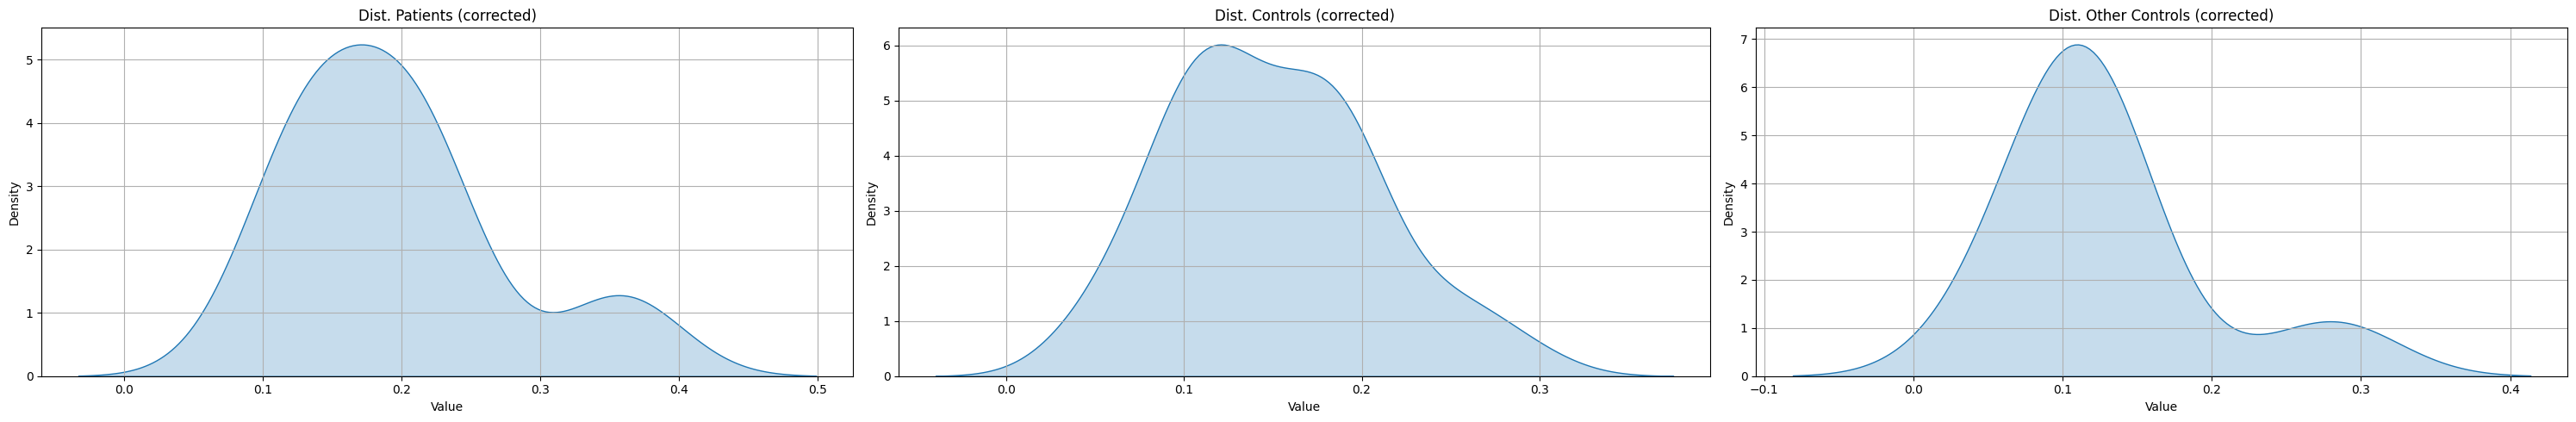

t-test: Patients vs controls
T-statistic: 2.4587989884773744
P-value: 0.01940428759768213
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Patients vs other controls
T-statistic: 2.3680046785012747
P-value: 0.03230937763053354
There is a statistically significant difference between distribA and distribB (p < 0.05).
t-test: Controls vs other controls
T-statistic: 0.8891896614469714
P-value: 0.39713020559409284
No statistically significant difference found (p >= 0.05).


In [16]:
plot_density(np.mean(np.mean(distance_to_ref_patients_corrected, axis=1), axis=1),np.mean(np.mean(distance_to_ref_controls_corrected, axis=1), axis=1),np.mean(np.mean(distance_to_ref_other_controls_corrected, axis=1), axis=1), titles=["Dist. Patients (corrected)", "Dist. Controls (corrected)", "Dist. Other Controls (corrected)"])

print("t-test: Patients vs controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_patients_corrected, axis=1), axis=1), np.mean(np.mean(distance_to_ref_controls_corrected, axis=1), axis=1))
print("t-test: Patients vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_patients_corrected, axis=1), axis=1), np.mean(np.mean(distance_to_ref_other_controls_corrected, axis=1), axis=1))
print("t-test: Controls vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_controls_corrected, axis=1), axis=1), np.mean(np.mean(distance_to_ref_other_controls_corrected, axis=1), axis=1))

print("In absolute value:")
plot_density(np.mean(np.mean(np.abs(distance_to_ref_patients_corrected), axis=1), axis=1),np.mean(np.mean(np.abs(distance_to_ref_controls_corrected), axis=1), axis=1),np.mean(np.mean(np.abs(distance_to_ref_other_controls_corrected), axis=1), axis=1), titles=["Dist. Patients (corrected)", "Dist. Controls (corrected)", "Dist. Other Controls (corrected)"])

print("t-test: Patients vs controls")
_ ,_ = do_t_test(np.mean(np.mean(np.abs(distance_to_ref_patients_corrected), axis=1), axis=1), np.mean(np.mean(np.abs(distance_to_ref_controls_corrected), axis=1), axis=1))
print("t-test: Patients vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(np.abs(distance_to_ref_patients_corrected), axis=1), axis=1), np.mean(np.mean(np.abs(distance_to_ref_other_controls_corrected), axis=1), axis=1))
print("t-test: Controls vs other controls")
_ ,_ = do_t_test(np.mean(np.mean(np.abs(distance_to_ref_controls_corrected), axis=1), axis=1), np.mean(np.mean(np.abs(distance_to_ref_other_controls_corrected), axis=1), axis=1))

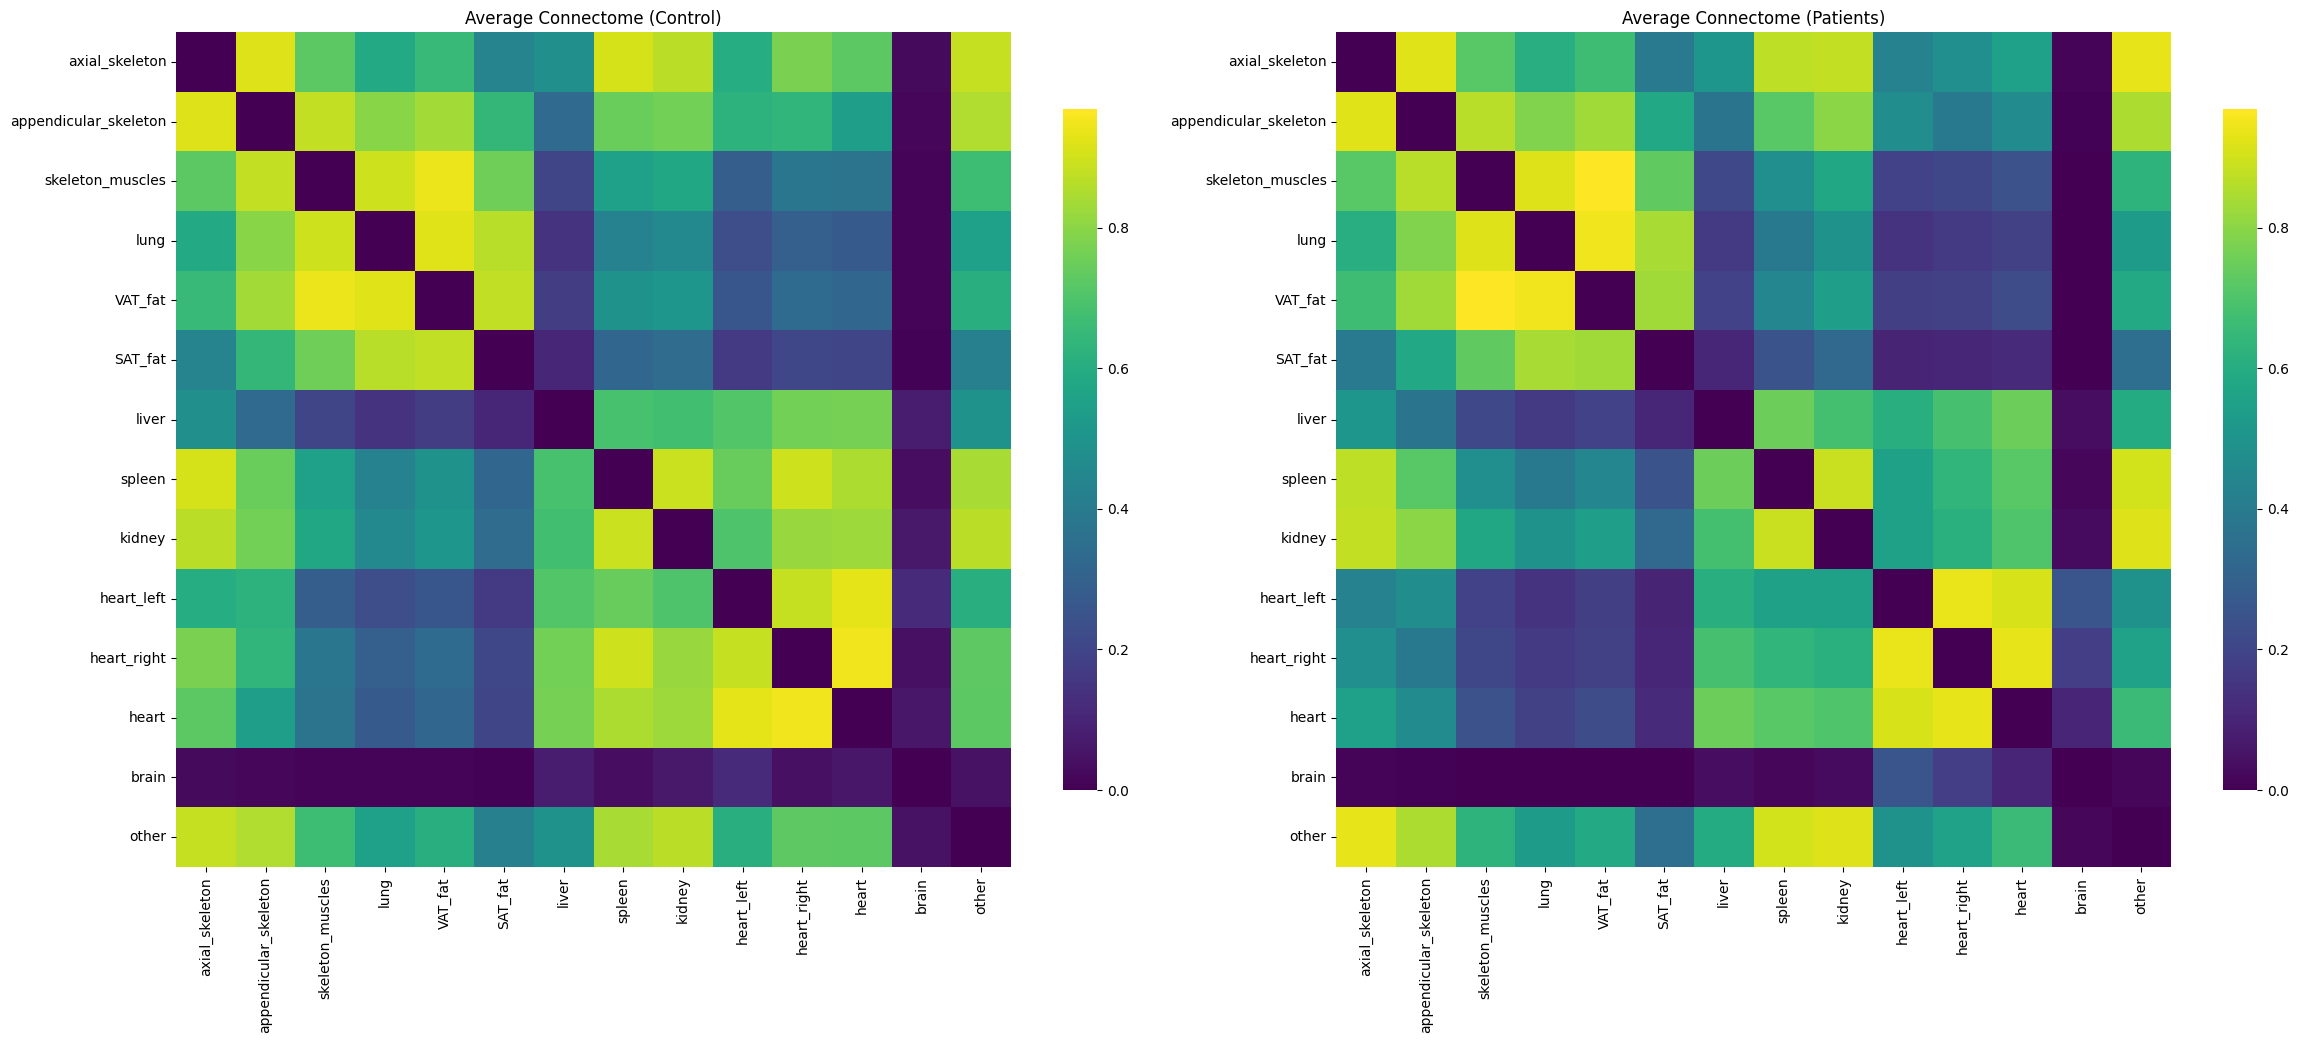

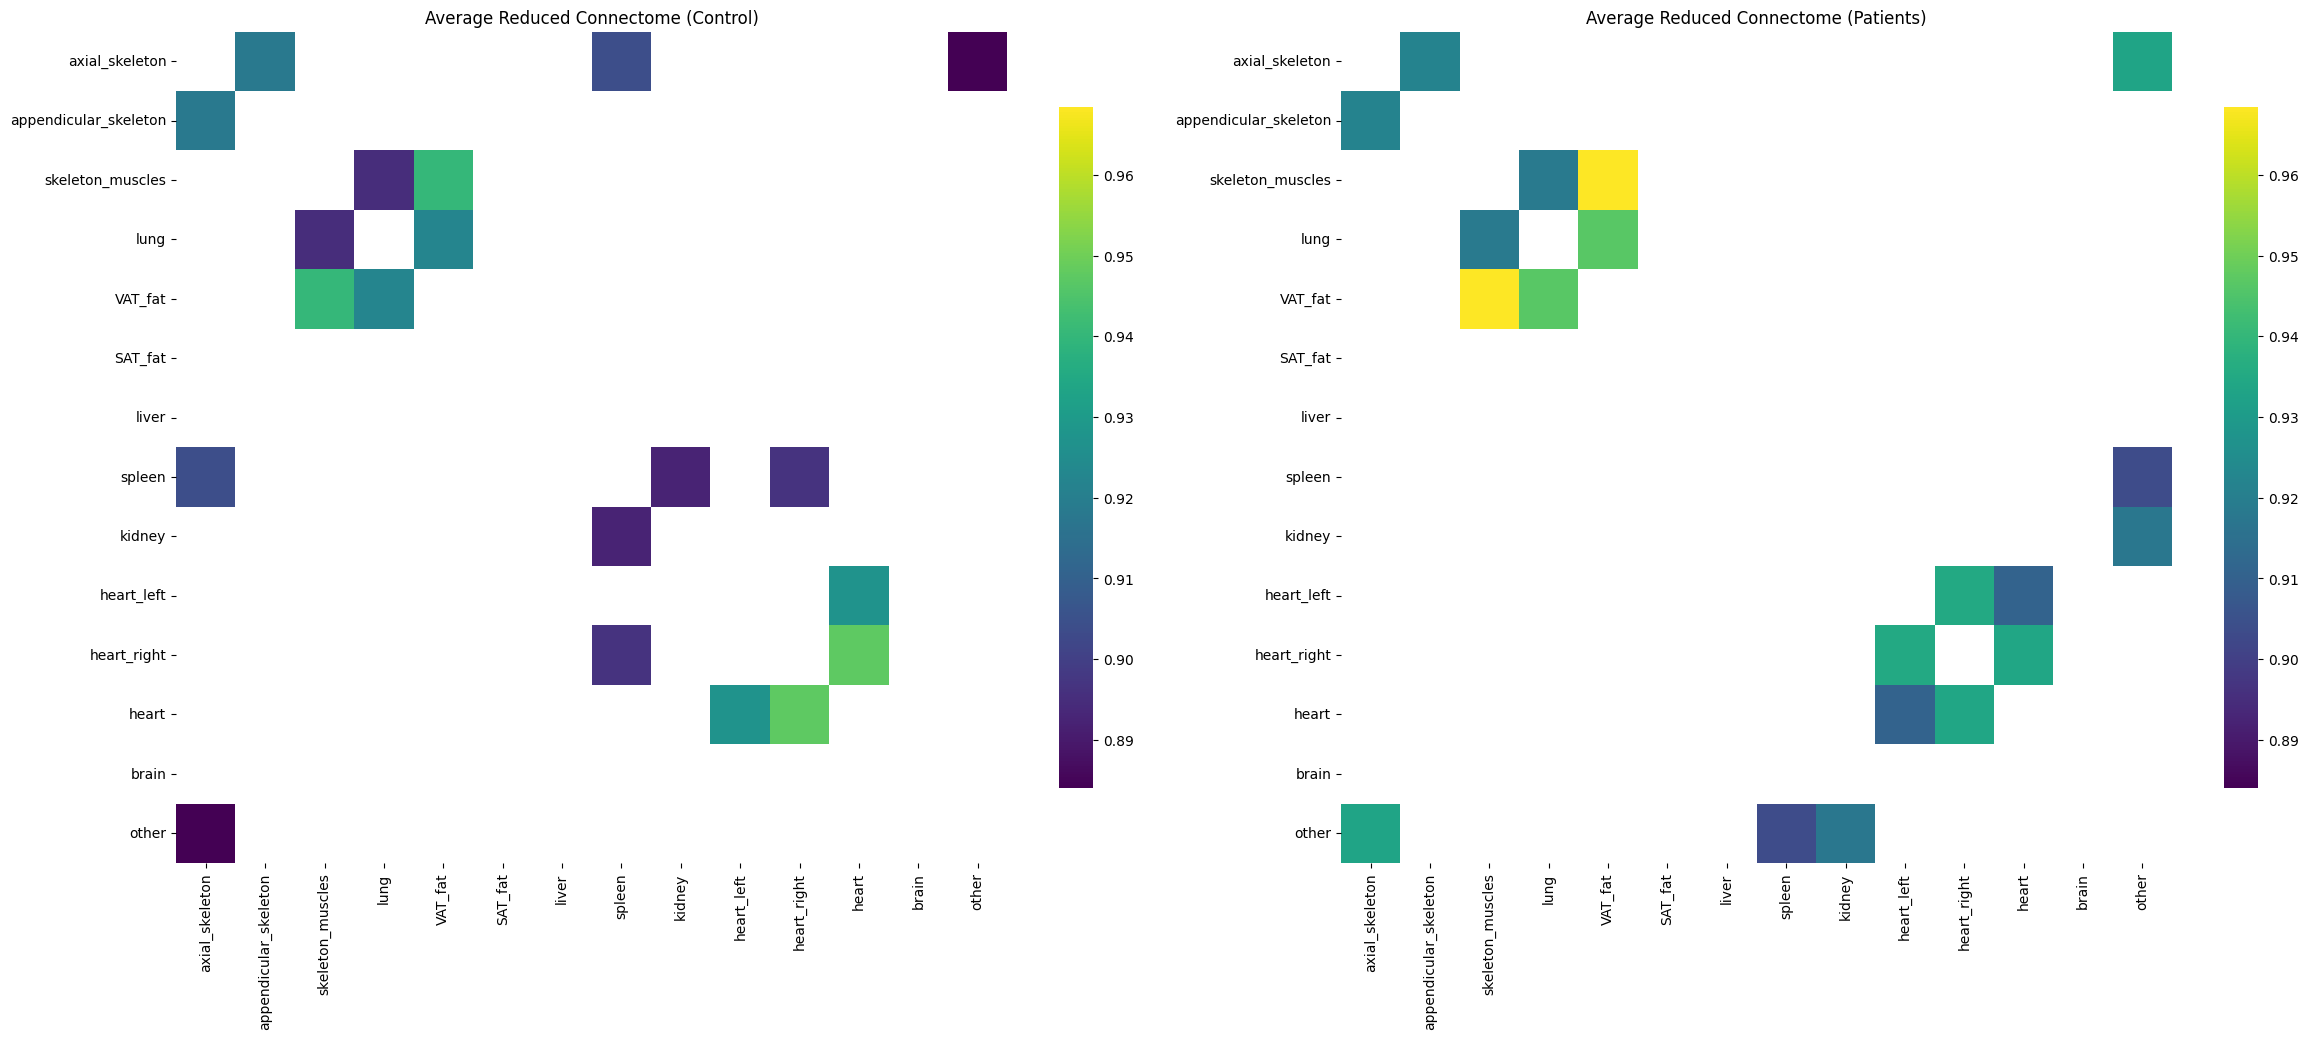

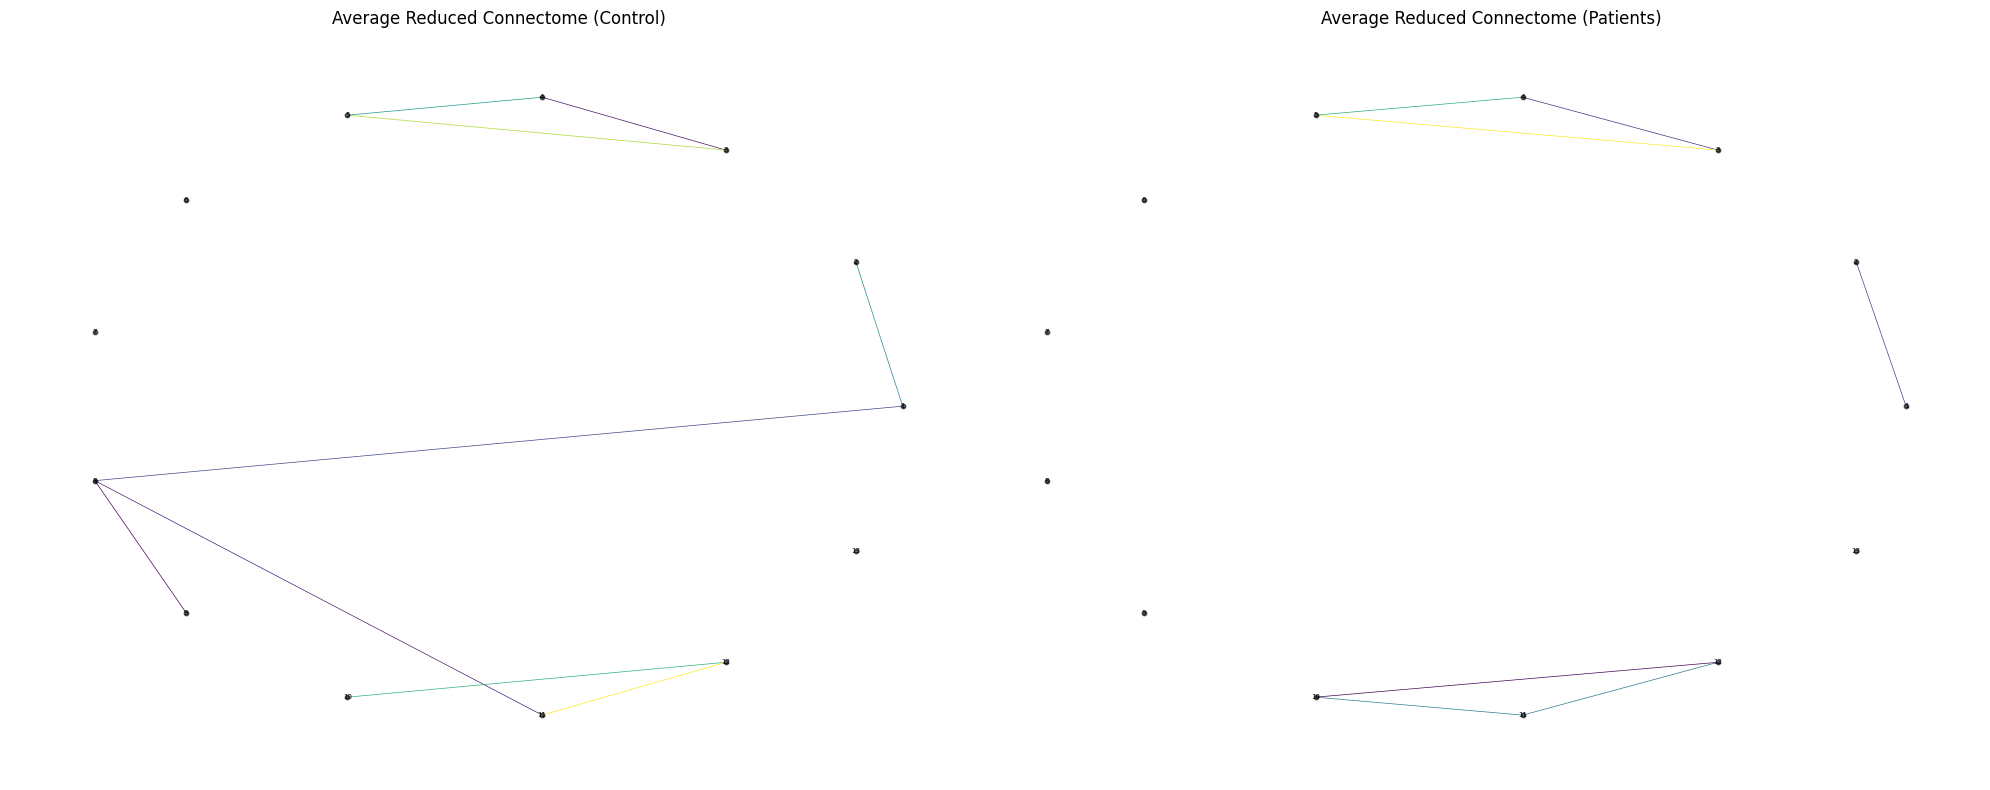

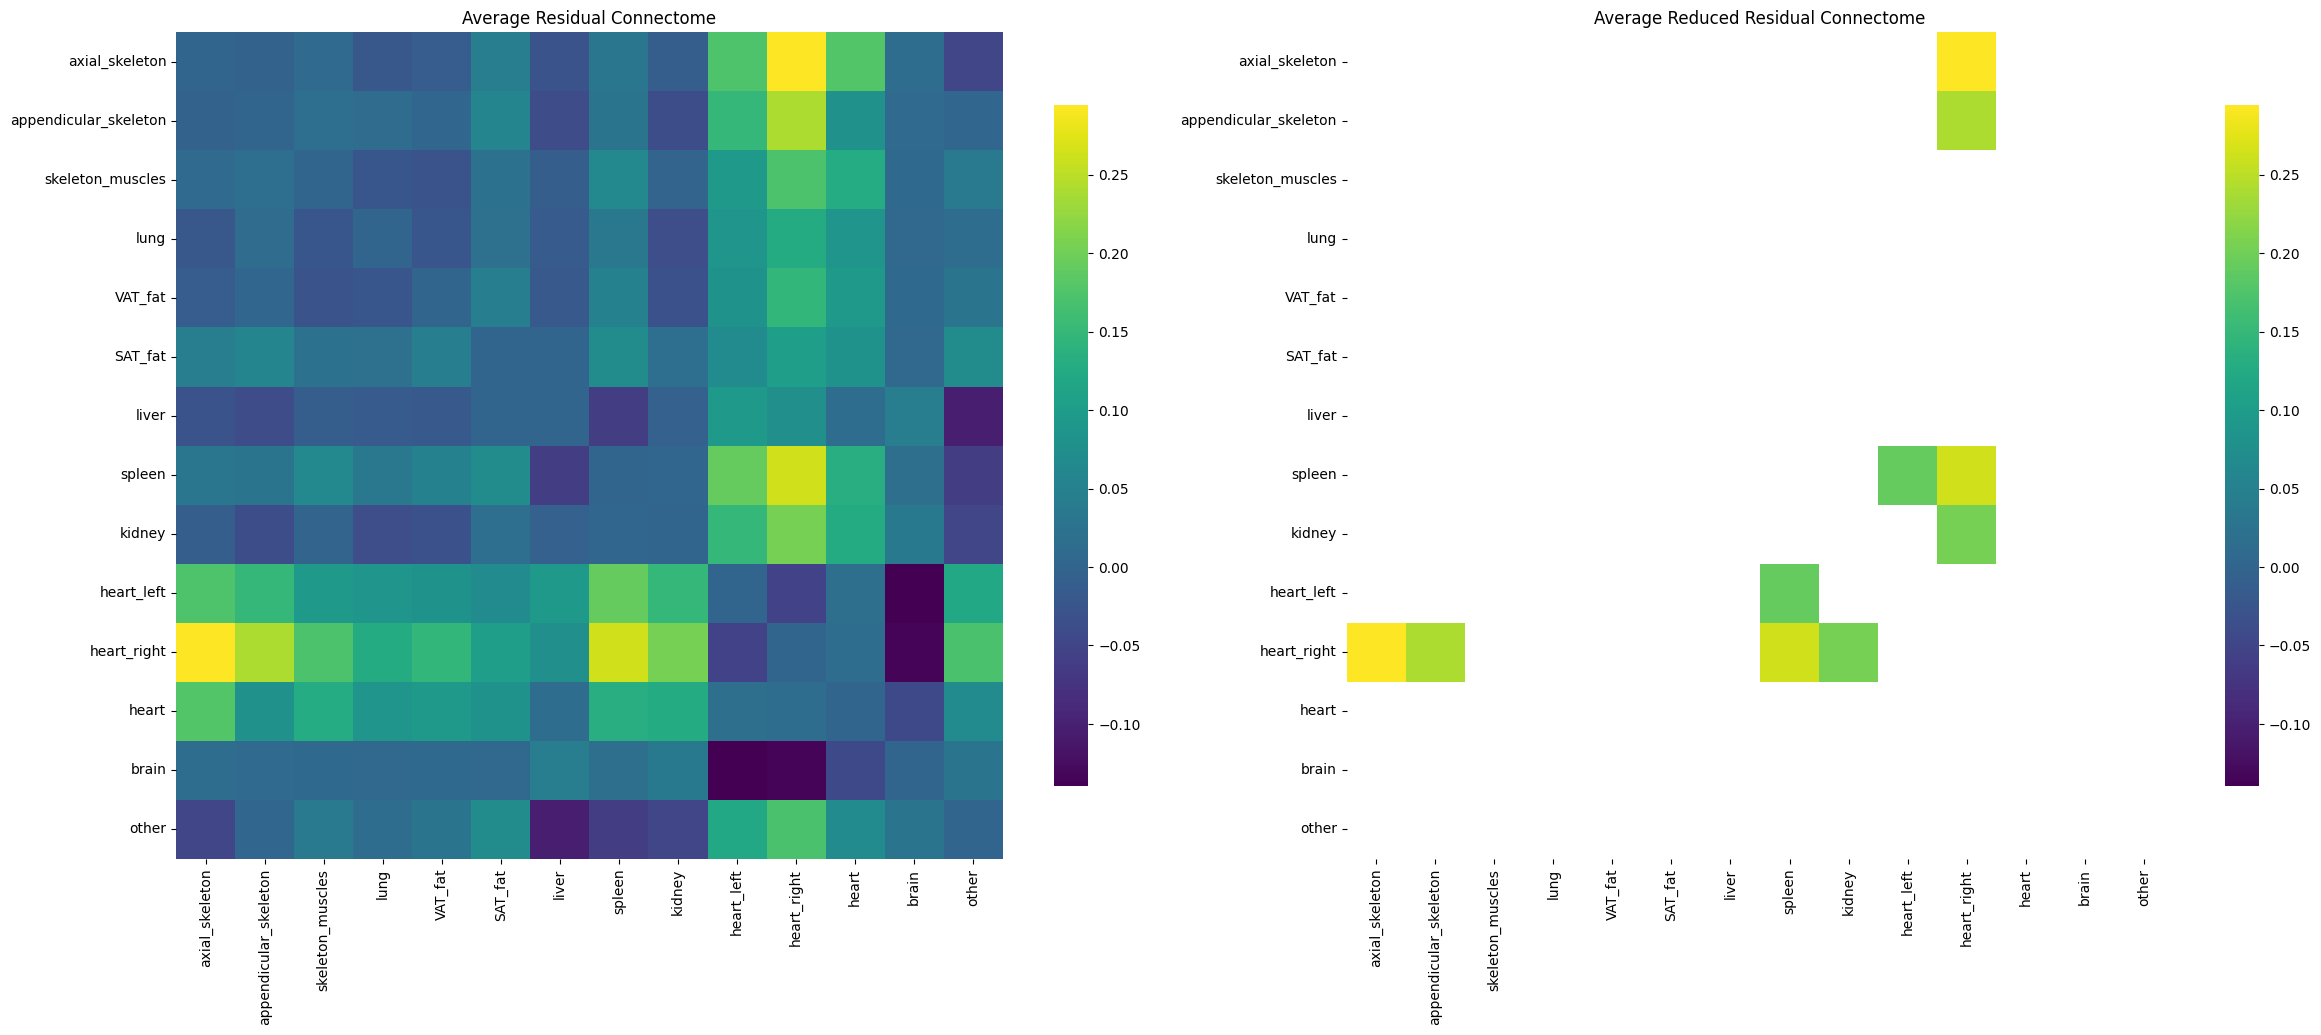

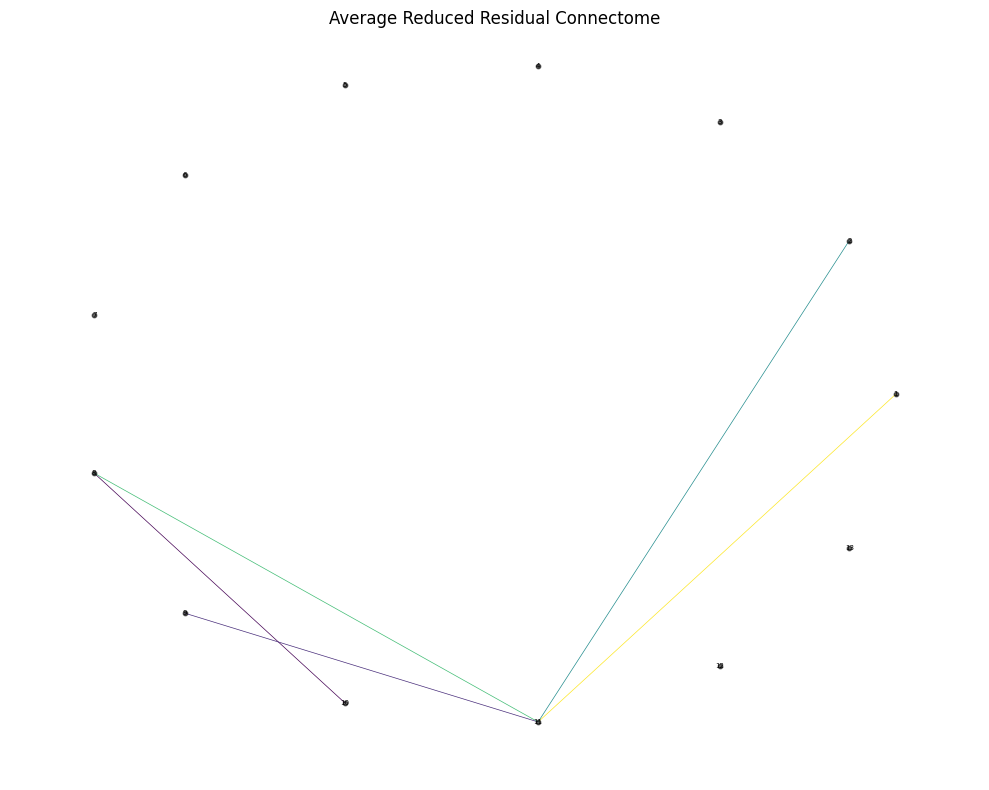

In [17]:
patients_matrix = np.mean([
    patient_matrices[__METRIC__]
    for patient_matrices in patients_connectomes.values()
], axis=0)

plot_correlogram(reference_matrix, patients_matrix, titles=["Average Connectome (Control)", "Average Connectome (Patients)"], organ_names_dict=organ_names_dict)

a = np.where(np.abs(reference_matrix) >= np.quantile(reference_matrix, q=0.9), reference_matrix, np.nan)
b = np.where(np.abs(patients_matrix) >= np.quantile(patients_matrix, q=0.9), patients_matrix, np.nan)

plot_correlogram(a, b, titles=["Average Reduced Connectome (Control)", "Average Reduced Connectome (Patients)"], organ_names_dict=organ_names_dict)
plot_connectome(build_graph_from_correlation_df(a, names=range(1, a.shape[0])), build_graph_from_correlation_df(b, names=range(1, b.shape[0])), titles=["Average Reduced Connectome (Control)", "Average Reduced Connectome (Patients)"])

avg_distance_to_ref= reference_matrix - patients_matrix
avg_distance_to_ref_reduced = np.where(np.abs(avg_distance_to_ref) >= np.quantile(avg_distance_to_ref, q=0.95), avg_distance_to_ref, np.nan)
plot_correlogram(avg_distance_to_ref, avg_distance_to_ref_reduced, titles=["Average Residual Connectome", "Average Reduced Residual Connectome"], organ_names_dict=organ_names_dict)
plot_connectome(build_graph_from_correlation_df(avg_distance_to_ref_reduced, names=range(1, avg_distance_to_ref_reduced.shape[0])), titles=["Average Reduced Residual Connectome"])



In [18]:
import pandas as pd
import numpy as np


def list_edges_by_decreasing_weights(avg_distance_to_ref_reduced, organ_names_dict):
    """
    Lists edges of a symmetric adjacency matrix by decreasing weights and finds
    the names of the vertices.

    Args:
        avg_distance_to_ref_reduced (numpy.ndarray): A symmetric adjacency matrix.

    Returns:
        list: A list of tuples, where each tuple represents an edge and its weight,
            sorted by decreasing weight.
        dict: A dictionary mapping vertex indices to organ names.
    """

    avg_distance_to_ref_reduced = np.nan_to_num(avg_distance_to_ref_reduced, nan=0.0)

    # Get the number of vertices
    num_vertices = avg_distance_to_ref_reduced.shape[0]

    # Create a list to store edges and their weights
    edges = []

    # Iterate over the upper triangle of the adjacency matrix
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            weight = avg_distance_to_ref_reduced[i, j]
            edges.append(((i, j), weight))

    # Sort edges by decreasing weights
    edges.sort(key=lambda x: x[1], reverse=True)

    return edges, organ_names_dict


edges, organ_names_dict = list_edges_by_decreasing_weights(
     avg_distance_to_ref, organ_names_dict
)

# Print the edges and their weights
for (u, v), weight in edges:
     if weight > 0:
        print(f"Edge ({organ_names_dict[u]}, {organ_names_dict[v]}) - Weight: {weight}")

Edge (axial_skeleton, heart_right) - Weight: 0.2942874862224396
Edge (spleen, heart_right) - Weight: 0.2621426492410298
Edge (appendicular_skeleton, heart_right) - Weight: 0.24106414206323584
Edge (kidney, heart_right) - Weight: 0.20403304358407404
Edge (spleen, heart_left) - Weight: 0.19115451185245225
Edge (axial_skeleton, heart) - Weight: 0.17721422155948363
Edge (axial_skeleton, heart_left) - Weight: 0.17272867829397598
Edge (skeleton_muscles, heart_right) - Weight: 0.17178654539589877
Edge (heart_right, other) - Weight: 0.16901139396258724
Edge (kidney, heart_left) - Weight: 0.14980491013799313
Edge (appendicular_skeleton, heart_left) - Weight: 0.1487634782377032
Edge (VAT_fat, heart_right) - Weight: 0.14653847958458696
Edge (spleen, heart) - Weight: 0.13310680493377203
Edge (skeleton_muscles, heart) - Weight: 0.12765268441111702
Edge (kidney, heart) - Weight: 0.12559810504935365
Edge (lung, heart_right) - Weight: 0.1254296356516828
Edge (heart_left, other) - Weight: 0.12023935068

### Experiment B: Let's go back to the standard approach and try to see what we can do

In [19]:
correlation_matrix_patients, correlation_matrix_patients_np, correlation_matrix_patients_pval, sp_matrix_patients, sp_matrix_patients_pval, patients_graph = build_correlation_matrix(patients_data, patients, names)
correlation_matrix_controls, correlation_matrix_controls_np, correlation_matrix_controls_pval, sp_matrix_controls, sp_matrix_controls_pval, controls_graph = build_correlation_matrix(controls_data, controls, names)

p_value_threshold = 0.05
correlation_diff_threshold = 0.1

# Initialize a counter for non-usable coefficients
non_pvalue_patients = 0
non_pvalue_controls = 0
non_sp_patients = 0
non_sp_controls = 0
non_pvalue_patients_t = 0
non_pvalue_controls_t = 0
non_sp_patients_t = 0
non_sp_controls_t = 0
total_patients = 0
total_patients_t = 0
total_controls = 0
total_controls_t = 0

total = len(correlation_matrix_patients.columns) **2

# Iterate through the correlation matrices and check the conditions
for col1 in correlation_matrix_patients.columns:
    for col2 in correlation_matrix_patients.columns:
        # Get the Pearson correlation, p-value, and Spearman correlation
        pearson_corr = correlation_matrix_patients.loc[col1, col2]
        pearson_pval = correlation_matrix_patients_pval.loc[col1, col2]
        spearman_corr = sp_matrix_patients.loc[col1, col2]
        
        non_pvalue_patients += pearson_pval >= p_value_threshold
        non_pvalue_patients_t += pearson_pval >= p_value_threshold and abs(pearson_corr) >=0.3
        non_sp_patients += abs(pearson_corr - spearman_corr) >= correlation_diff_threshold
        non_sp_patients_t += abs(pearson_corr - spearman_corr) >= correlation_diff_threshold and abs(pearson_corr) >=0.3
        total_patients += (pearson_pval >= p_value_threshold or abs(pearson_corr - spearman_corr) >= correlation_diff_threshold)
        total_patients_t += (pearson_pval >= p_value_threshold or abs(pearson_corr - spearman_corr) >= correlation_diff_threshold) and abs(pearson_corr) >=0.3

        pearson_corr_c = correlation_matrix_controls.loc[col1, col2]
        pearson_pval_c = correlation_matrix_controls_pval.loc[col1, col2]
        spearman_corr_c = sp_matrix_controls.loc[col1, col2]
        
        non_pvalue_controls += pearson_pval_c >= p_value_threshold
        non_sp_controls += abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold
        non_pvalue_controls_t += pearson_pval_c >= p_value_threshold  and abs(pearson_corr_c) >=0.3
        non_sp_controls_t += abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold and abs(pearson_corr_c) >=0.3
        total_controls += (pearson_pval_c >= p_value_threshold or abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold) 
        total_controls_t += (pearson_pval_c >= p_value_threshold or abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold) and abs(pearson_corr_c) >=0.3 


print("All failures summary:")
print(f"For CONTROLES : {non_pvalue_controls} p-value failures ({non_pvalue_controls*100/total:.3}%), {non_sp_controls} spearman failures ({non_sp_controls*100/total:.3}%), {total_controls} total failures ({total_controls*100/total:.3}%)")
print(f"For PATIENTS : {non_pvalue_patients} p-value failures ({non_pvalue_patients*100/total:.3}%), {non_sp_patients} spearman failures ({non_sp_patients*100/total:.3}%), {total_patients} total failures ({total_patients*100/total:.3}%)")
print("If we only consider coefficients that are higher than 0.3: (i.e. that will remain in the connectome)")
print(f"For CONTROLES : {non_pvalue_controls_t} p-value failures ({non_pvalue_controls_t*100/total:.3}%), {non_sp_controls_t} spearman failures ({non_sp_controls_t*100/total:.3}%), {total_controls_t} total failures ({total_controls_t*100/total:.3}%)")
print(f"For PATIENTS : {non_pvalue_patients_t} p-value failures ({non_pvalue_patients_t*100/total:.3}%), {non_sp_patients_t} spearman failures ({non_sp_patients_t*100/total:.3}%), {total_patients_t} total failures ({total_patients_t*100/total:.3}%)")


All failures summary:
For CONTROLES : 56 p-value failures (28.6%), 48 spearman failures (24.5%), 80 total failures (40.8%)
For PATIENTS : 122 p-value failures (62.2%), 58 spearman failures (29.6%), 132 total failures (67.3%)
If we only consider coefficients that are higher than 0.3: (i.e. that will remain in the connectome)
For CONTROLES : 0 p-value failures (0.0%), 22 spearman failures (11.2%), 22 total failures (11.2%)
For PATIENTS : 26 p-value failures (13.3%), 12 spearman failures (6.12%), 36 total failures (18.4%)


In [20]:
def fisher_transform(r):
    """
    Apply Fisher's r-to-z transformation.
    Clamps r to avoid division errors.
    """
    r = np.clip(r, -0.9999, 0.9999)
    return 0.5 * np.log((1 + r) / (1 - r))

In [21]:
from scipy.stats import norm
def compute_ZCC_and_p_value(r_N, r_N1, N):
    """
    Compute the Z-score (ZCC) and p-value for the difference between Pearson correlations 
    for two matrices of correlations computed with N and (N+1) samples.

    Parameters:
    - r_N  : Pearson correlation matrix for N samples (NumPy array)
    - N    : Number of samples in the first dataset (must be > 3)
    - r_N1 : Pearson correlation matrix for the same N samples + 1 new sample

    Returns:
    - ZCC  : Z-score matrix of correlation differences
    - p_val: P-value matrix of correlation differences
    """
    if N <= 3:
        raise ValueError("Sample size N must be greater than 3 for valid standard error computation.")

    # Step 1: Compute Fisher Z-transforms
    Z_N = fisher_transform(r_N)
    Z_N1 = fisher_transform(r_N1)
    
    # Step 2: Compute standard errors for each correlation
    SE_N = 1 / np.sqrt(N - 3)
    SE_N1 = 1 / np.sqrt((N + 1) - 3)
    
    # Step 3: Compute ZCC (Z-score matrix for correlation differences)
    ZCC = (Z_N1 - Z_N) / np.sqrt(SE_N**2 + SE_N1**2)
    
    # Step 4: Compute two-tailed p-value matrix
    p_value = 2 * norm.cdf(-np.abs(ZCC))
    
    return ZCC, p_value

In [22]:
patient_correlation_matrices = dict()
other_controls_correlation_matrices = dict()

for patient in patients_list:
    l = dict()
    l[patient] = patients_data[patient]
    c_set = set(controls)
    c_set.add(patient)
    c, c_np, cpval, s, spval, g = build_correlation_matrix(controls_data | l, c_set, names)
    #z_matrix, z_p_matrix = build_significance_matrix_for_diff(correlation_matrix_controls,c, len(controls_list), Fisher=True)
    z_matrix, z_p_matrix = compute_ZCC_and_p_value(correlation_matrix_controls_np,c_np, len(controls_list))
    patient_correlation_matrices[patient] = dict(correlation_matrix= c, correlation_matrix_np=c_np, cor_pvalue_matrix=cpval,
                                              sp_matrix=s, sp_pvalue_matrix= spval, graph=g, z_matrix=z_matrix, z_p_matrix=z_p_matrix)
    #overall_zmean = z_matrix.abs().mean().mean()
    overall_zmean = np.mean(np.abs(z_matrix))
    valid_coeffs = 0
    for col1 in range(z_p_matrix.shape[0]):#z_p_matrix.columns:
        for col2 in range(z_p_matrix.shape[1]):#z_p_matrix.columns:
            #if z_p_matrix.loc[col1, col2] <= 0.05:
            if z_p_matrix[col1, col2] <= 0.05:
                valid_coeffs += 1

    print(f"For test patient {patient}: overall z-score of {overall_zmean:.3} (abs. mean) with {valid_coeffs} significant scores ({valid_coeffs*100/total:.3}%)")

for patient in other_controls_list:
    l = dict()
    l[patient] = other_controls_data[patient]
    c_set = set(controls)
    c_set.add(patient)
    c, c_np, cpval, s, spval, g = build_correlation_matrix(controls_data | l, c_set, names, graph_threshold=-1)
    z_matrix, z_p_matrix = compute_ZCC_and_p_value(correlation_matrix_controls_np,c_np, len(controls_list))
    other_controls_correlation_matrices[patient] = dict(correlation_matrix= c, correlation_matrix_np=c_np, cor_pvalue_matrix=cpval,
                                              sp_matrix=s, sp_pvalue_matrix= spval, graph=g, z_matrix=z_matrix, z_p_matrix=z_p_matrix)
    #overall_zmean = z_matrix.abs().mean().mean()
    overall_zmean = np.mean(np.abs(z_matrix))
    valid_coeffs = 0
    for col1 in range(z_p_matrix.shape[0]):#z_p_matrix.columns:
        for col2 in range(z_p_matrix.shape[1]):#z_p_matrix.columns:
            #if z_p_matrix.loc[col1, col2] <= 0.05:
            if z_p_matrix[col1, col2] <= 0.05:
                valid_coeffs += 1

    print(f"For other control {patient}: overall z-score of {overall_zmean:.3} (abs. mean) with {valid_coeffs} significant scores ({valid_coeffs*100/total:.3}%)")

For test patient 19640625: overall z-score of 0.197 (abs. mean) with 0 significant scores (0.0%)
For test patient 19610703: overall z-score of 0.0557 (abs. mean) with 0 significant scores (0.0%)
For test patient 19690510: overall z-score of 0.0892 (abs. mean) with 0 significant scores (0.0%)
For test patient 19631101: overall z-score of 0.0202 (abs. mean) with 0 significant scores (0.0%)
For test patient 19820922: overall z-score of 0.0529 (abs. mean) with 0 significant scores (0.0%)
For test patient 19710705: overall z-score of 0.168 (abs. mean) with 0 significant scores (0.0%)
For test patient 19700303: overall z-score of 0.061 (abs. mean) with 0 significant scores (0.0%)
For test patient 19701209: overall z-score of 0.0957 (abs. mean) with 0 significant scores (0.0%)
For test patient 19660525: overall z-score of 0.0132 (abs. mean) with 0 significant scores (0.0%)
For test patient 19711209: overall z-score of 0.0261 (abs. mean) with 0 significant scores (0.0%)
For test patient 197203

0.36363636363636365
0.0
T-statistic: 1.7728511407550827
P-value: 0.08746932155166567
No statistically significant difference found (p >= 0.05).


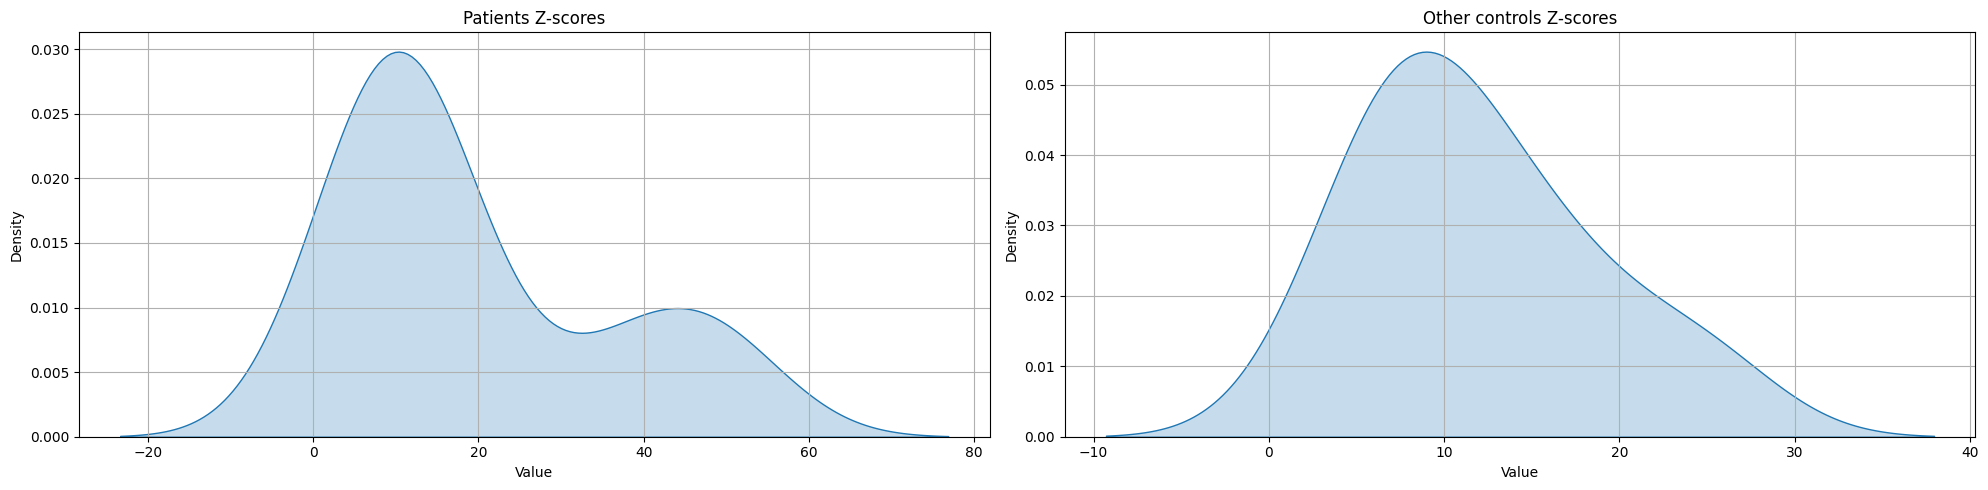

19.363668504685084 11.970098676438772


In [23]:
patients_total_zcores = [np.sum(np.abs(pmatrices["z_matrix"])) for pmatrices in patient_correlation_matrices.values()]
other_controls_total_zcores = [np.sum(np.abs(pmatrices["z_matrix"])) for pmatrices in other_controls_correlation_matrices.values()]
patients_total_zcores_successes = [np.sum(np.where(pmatrices["z_p_matrix"] <= 0.05, 1, 0)) for pmatrices in patient_correlation_matrices.values()]
other_controls_total_zcores_successes = [np.sum(np.where(pmatrices["z_p_matrix"] <= 0.05, 1, 0)) for pmatrices in other_controls_correlation_matrices.values()]

print(np.mean(patients_total_zcores_successes))
print(np.mean(other_controls_total_zcores_successes))

_, _ = do_t_test(patients_total_zcores, other_controls_total_zcores)
plot_density(patients_total_zcores, other_controls_total_zcores, titles=["Patients Z-scores", "Other controls Z-scores"])
print(np.mean(patients_total_zcores), np.mean(other_controls_total_zcores))

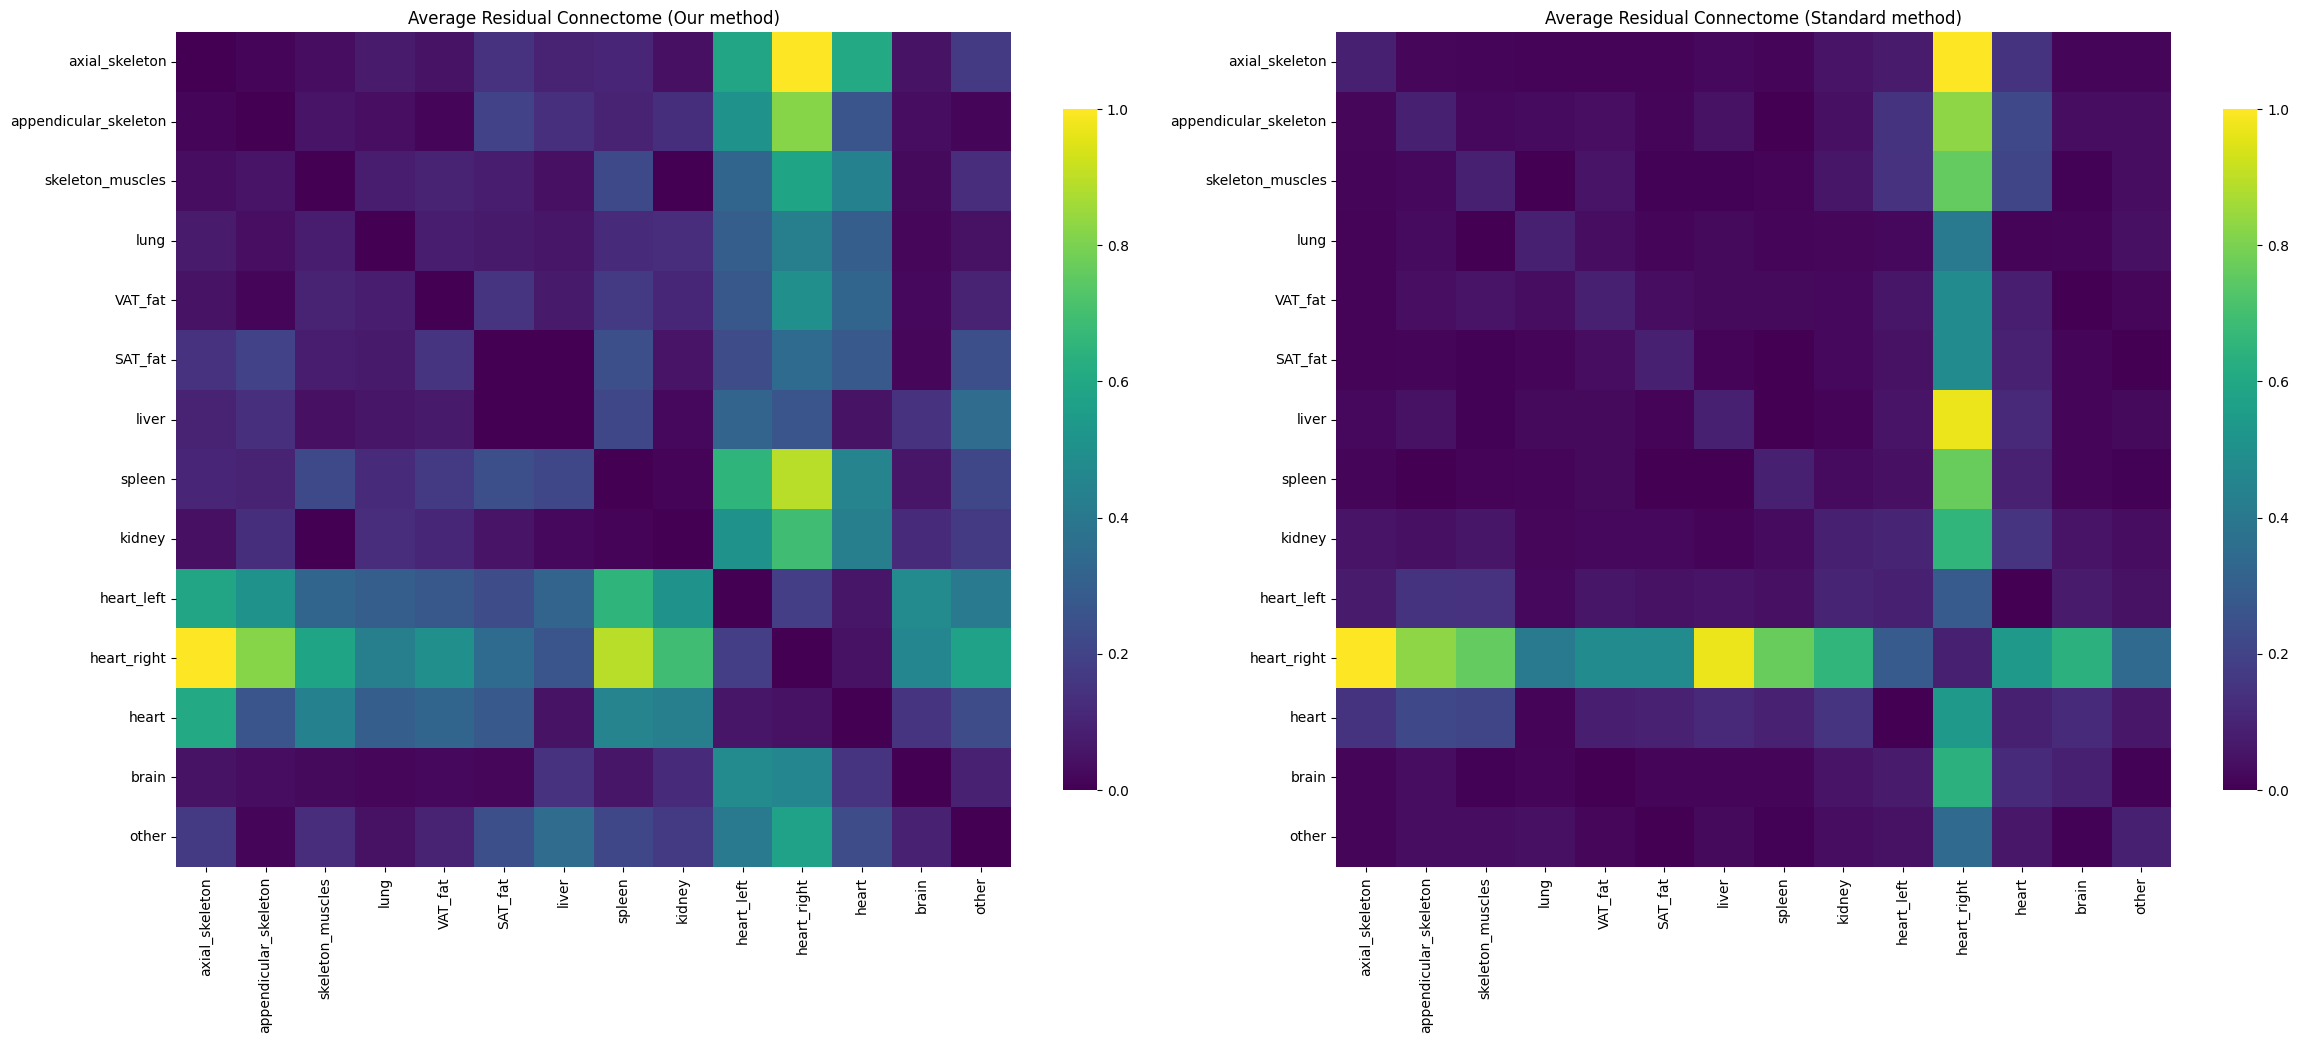

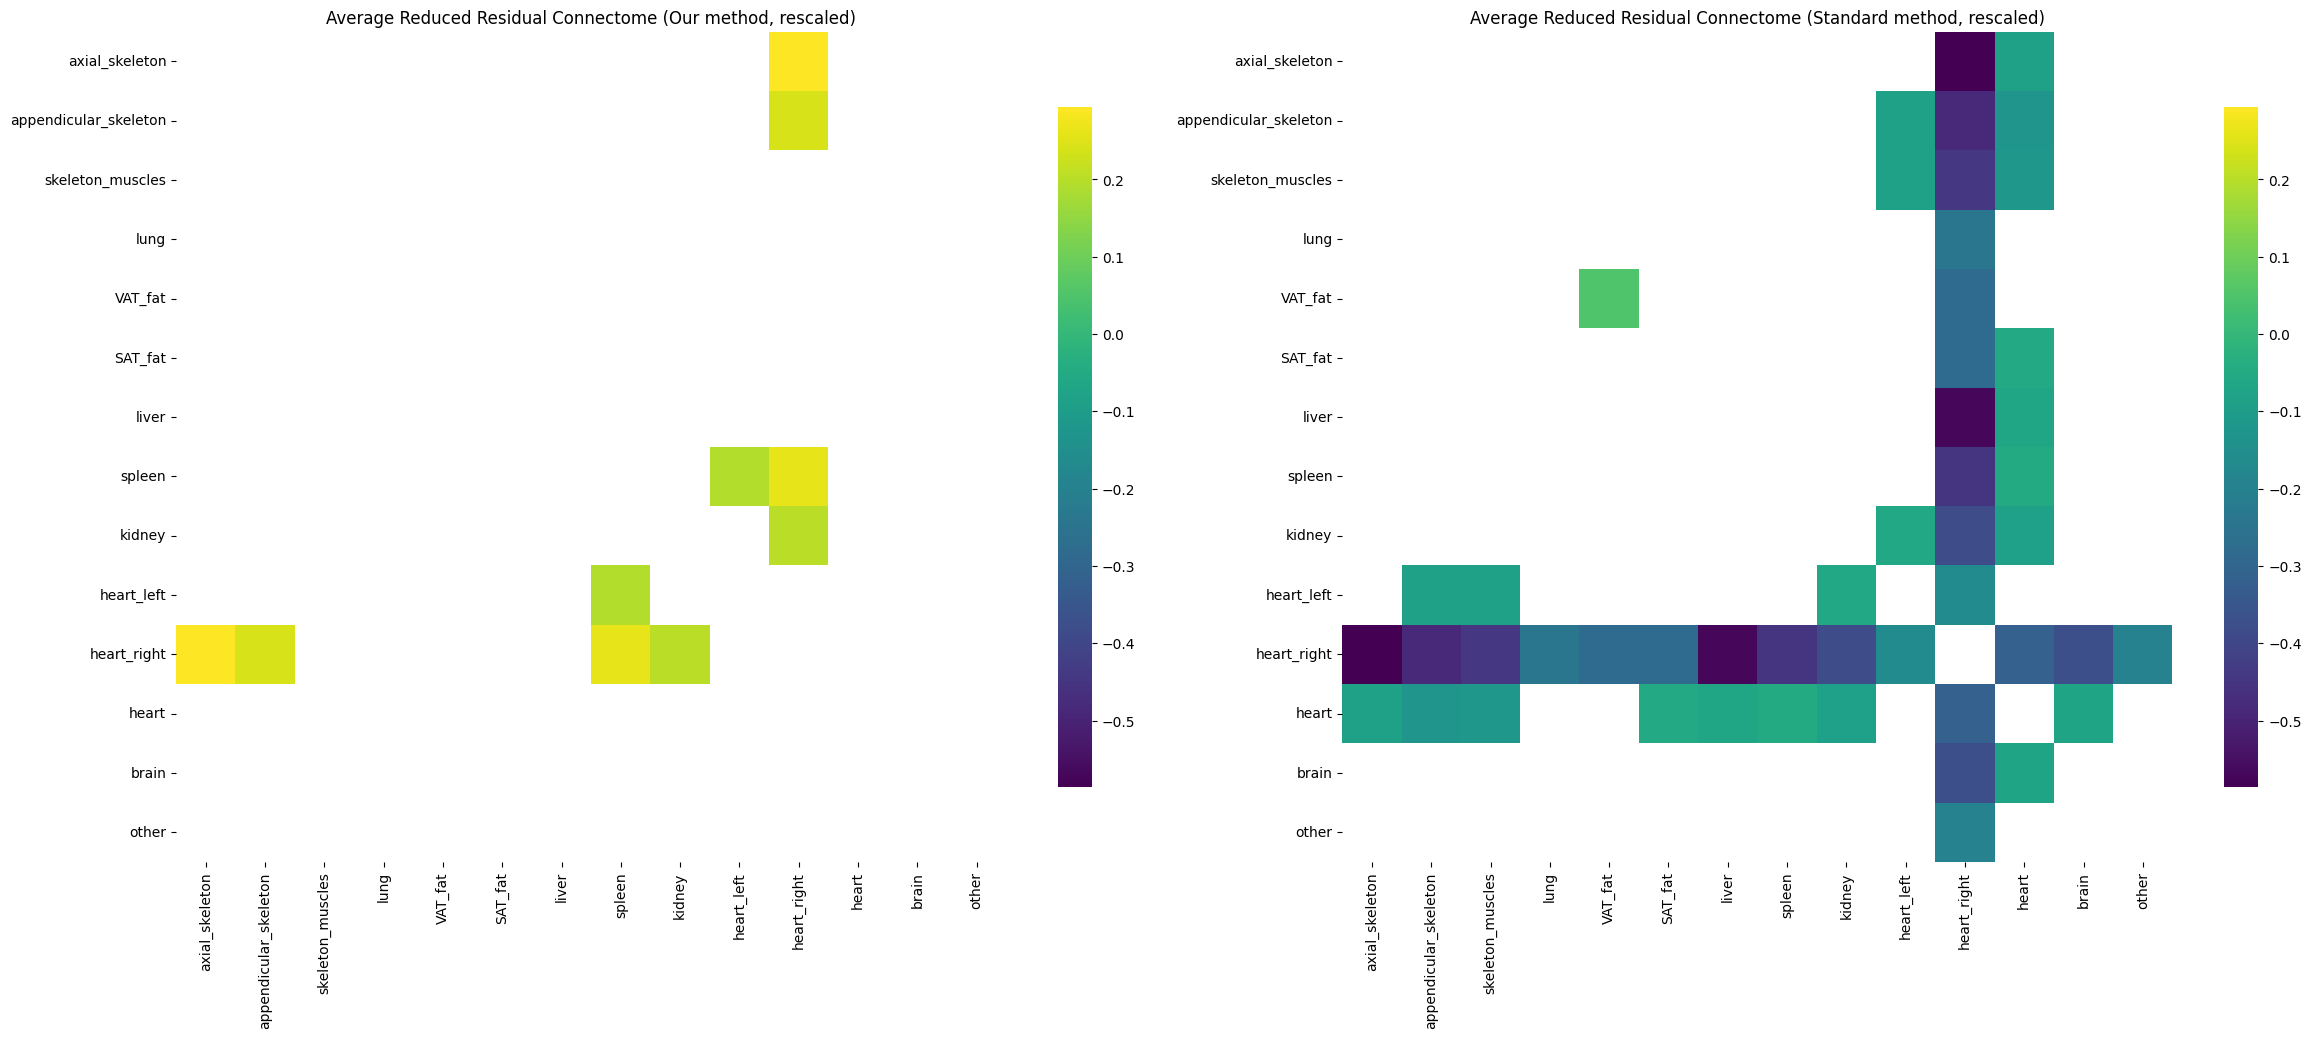

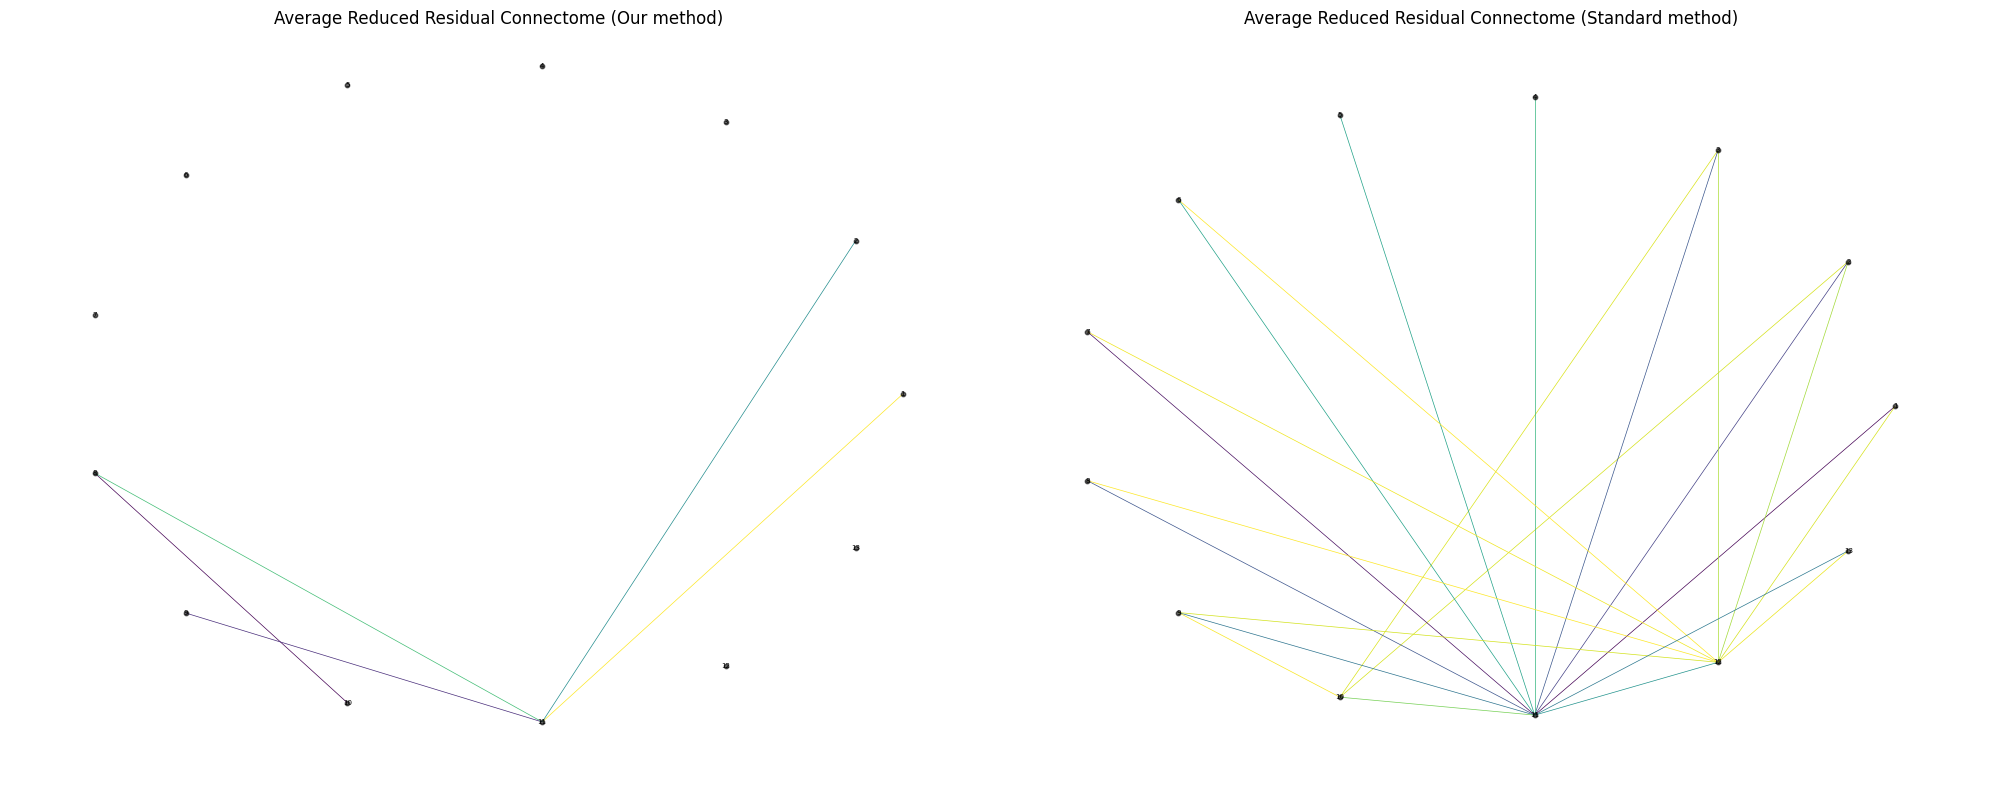

In [24]:
average_z_matrix_patients = np.mean([pmatrices["z_matrix"] for pmatrices in patient_correlation_matrices.values()], axis=0)
average_z_matrix_patients_reduced = np.where(np.abs(average_z_matrix_patients) >= np.quantile(average_z_matrix_patients, q=0.9999), average_z_matrix_patients, np.nan)

plot_correlogram(np.abs(avg_distance_to_ref)/np.max(np.abs(avg_distance_to_ref)), np.abs(average_z_matrix_patients)/np.max(np.abs(average_z_matrix_patients)), titles=["Average Residual Connectome (Our method)", "Average Residual Connectome (Standard method)"], organ_names_dict=organ_names_dict)
plot_correlogram(avg_distance_to_ref_reduced, average_z_matrix_patients_reduced, titles=["Average Reduced Residual Connectome (Our method, rescaled)", "Average Reduced Residual Connectome (Standard method, rescaled)"], organ_names_dict=organ_names_dict)

plot_connectome(build_graph_from_correlation_df(avg_distance_to_ref_reduced, names=range(1, avg_distance_to_ref_reduced.shape[0])), 
                build_graph_from_correlation_df(average_z_matrix_patients_reduced, names=range(1, average_z_matrix_patients_reduced.shape[0])), 
                titles=["Average Reduced Residual Connectome (Our method)", "Average Reduced Residual Connectome (Standard method)"])

/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_9776/465923572.py:8: RuntimeWarning: invalid value encountered in divide
  our_net_diff_group = (reference_matrix - patients_matrix) / (reference_matrix + patients_matrix)


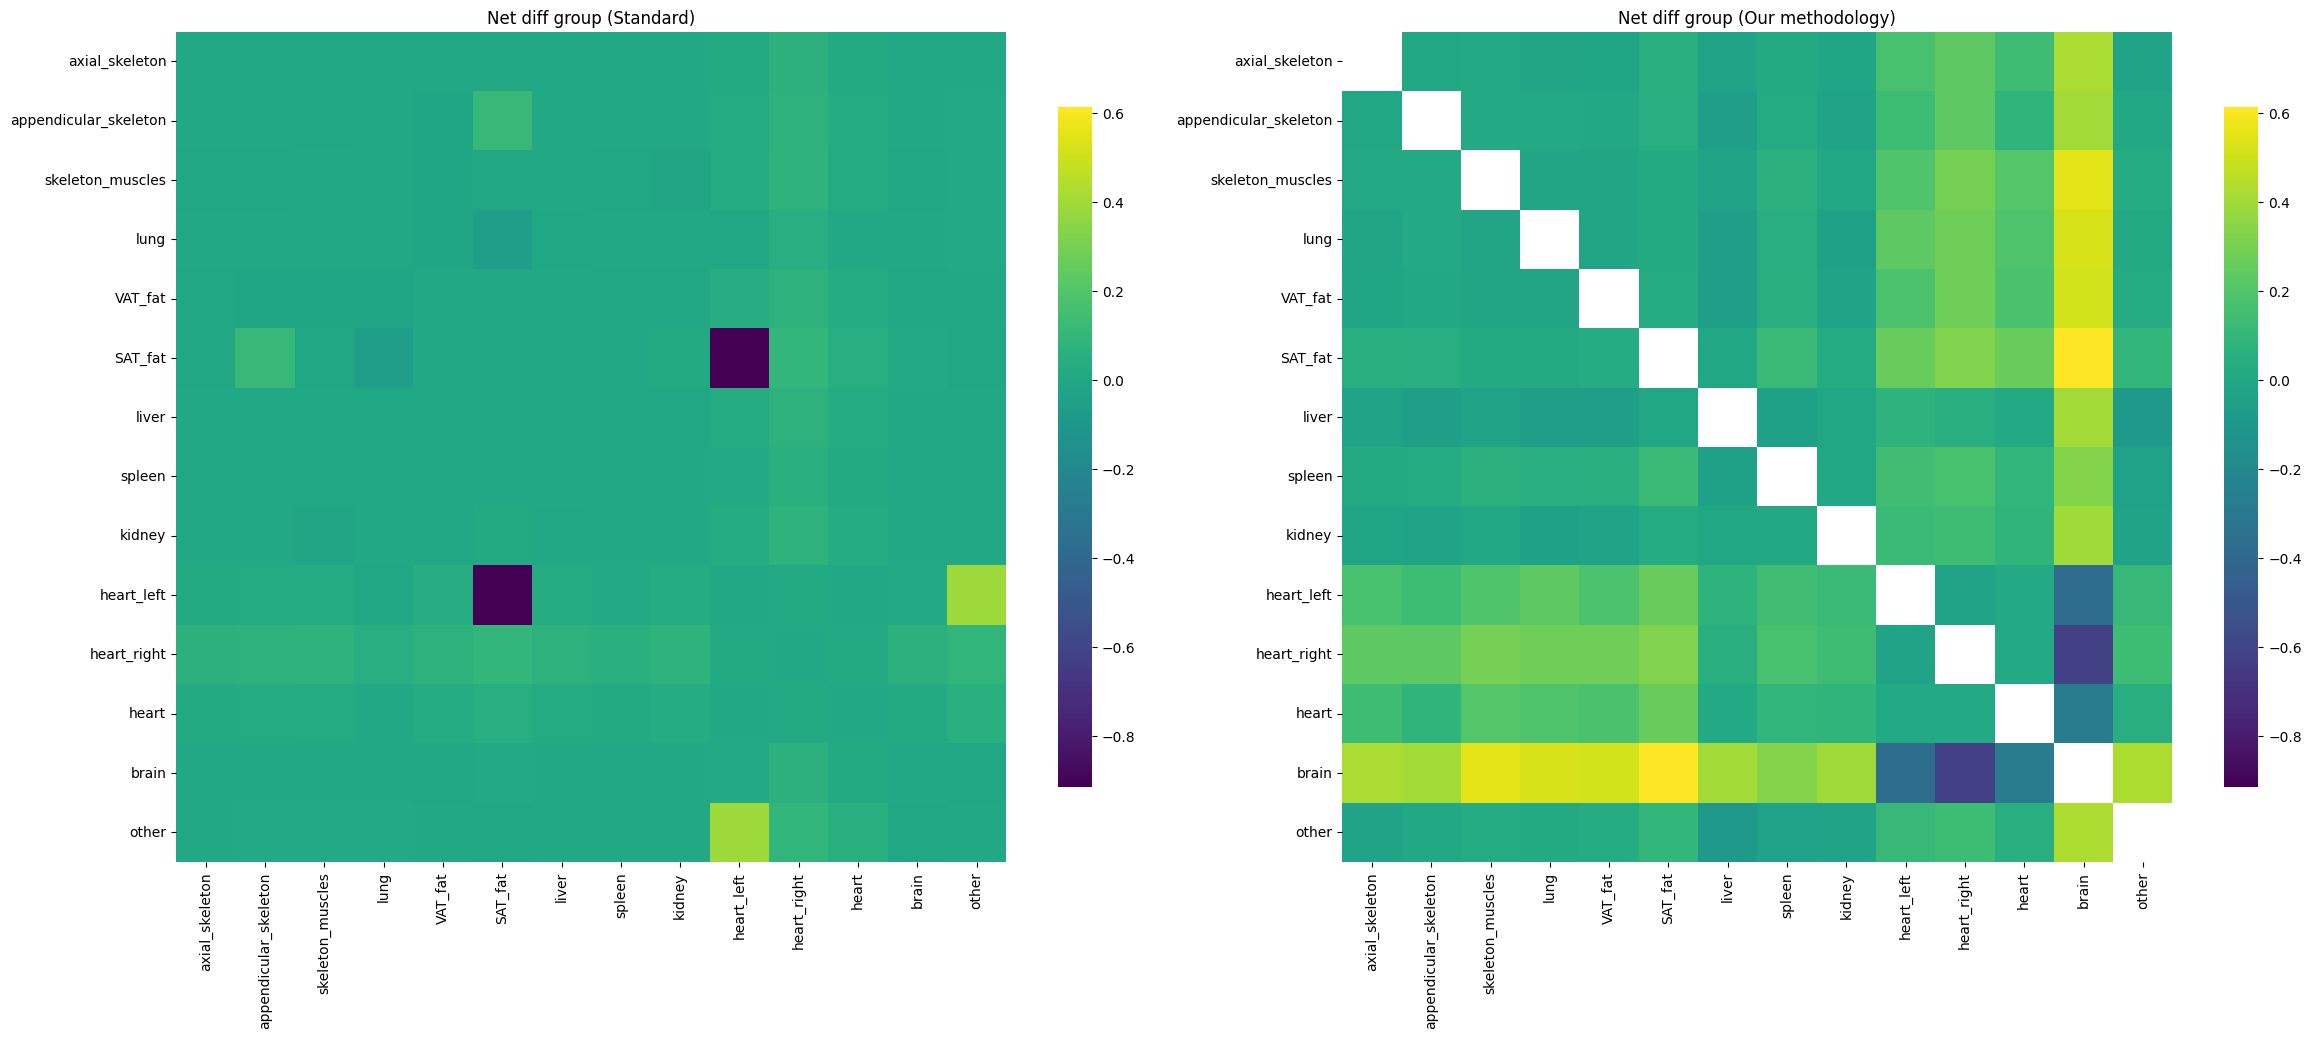

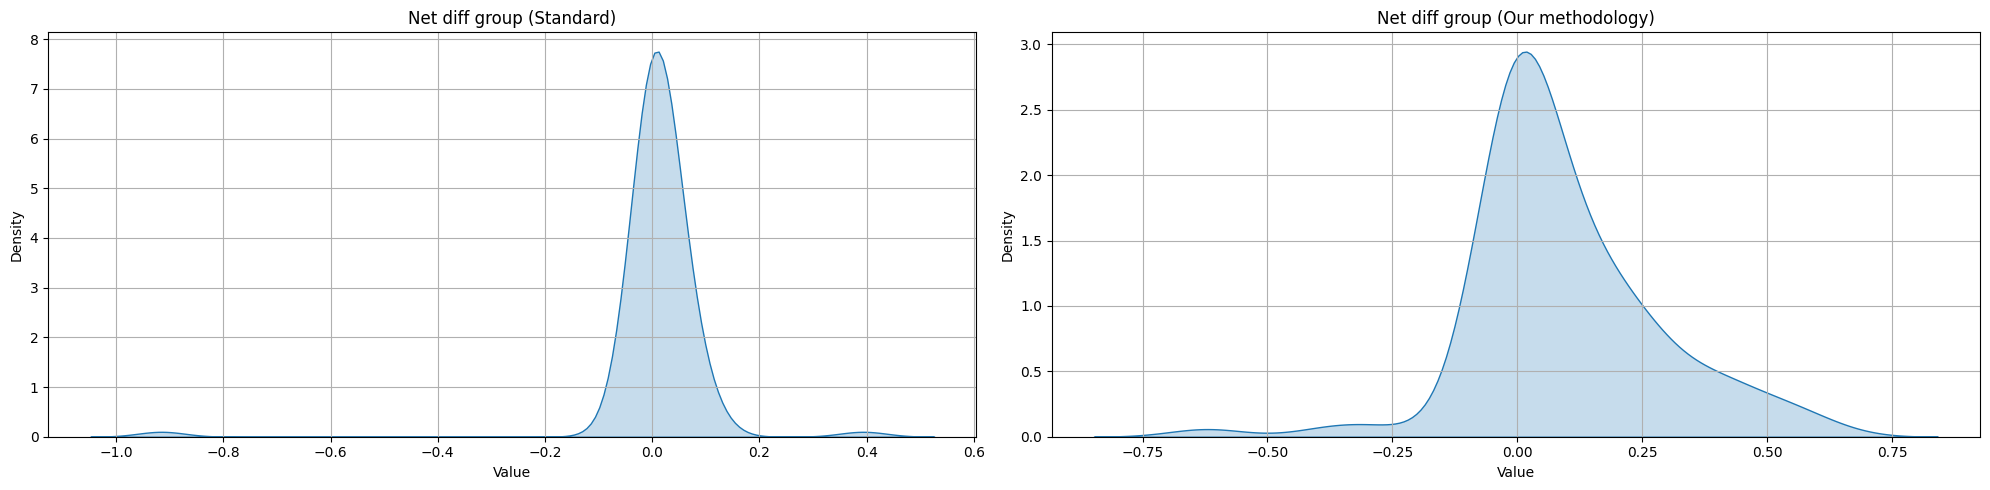

In [25]:
matrices_patients = np.mean([pmatrices["correlation_matrix_np"] for pmatrices in patient_correlation_matrices.values()], axis=0)
matrices_controls = correlation_matrix_controls_np

net_diff_group = (matrices_controls - matrices_patients) / (matrices_controls + matrices_patients)
# as there is numerical instability, we remove too high values
net_diff_group_stabilized = np.where(np.abs(net_diff_group) < 1.2, net_diff_group, np.nan)

our_net_diff_group = (reference_matrix - patients_matrix) / (reference_matrix + patients_matrix)

plot_correlogram(net_diff_group_stabilized, our_net_diff_group, titles=["Net diff group (Standard)", "Net diff group (Our methodology)"], organ_names_dict=organ_names_dict)
plot_density(upper_triangle_to_vector(net_diff_group_stabilized), upper_triangle_to_vector(our_net_diff_group), titles=["Net diff group (Standard)", "Net diff group (Our methodology)"])

## VAE Experiment

In [26]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 

import matplotlib.pyplot as plt

from VAE.utils import *
from VAE.ConvVAE import *

combined_connectomes =  controls_connectomes | patients_connectomes | other_controls_connectomes

num_spirals = 2
num_points = len(combined_connectomes)

# Generate a 5-dimensional spiral dataset
dimensions = len(organ_names_dict)
features = len(organ_names_dict)

batch_size = 16
epochs = 20
latent_dim = 150
num_examples_to_generate = 4

max_training = None
max_testing = None

In [27]:
x_train_t, x_test_t = remove_last_n_elements_and_slice(combined_connectomes, 16)
x_train = np.array([patient_matrices[__METRIC__] for patient_matrices in (x_train_t).values()])
x_test = np.array([patient_matrices[__METRIC__] for patient_matrices in (x_test_t).values()])
y_train = np.array([0 if patient in patients_connectomes else 1 for patient in (x_train_t).keys()])
y_test = np.array([0 if patient in patients_connectomes else 1 for patient in (x_test_t).keys()])
del x_train_t, x_test_t
print(x_train, y_train, x_test, y_test)
print("Data shape:", x_train.shape)  # Should be (n_samples, length, n_features)
print("Labels shape:", y_train.shape)  # Should be (n_samples,)


[[[0.00000000e+00 8.48530122e-01 4.94819616e-01 ... 7.74851918e-01
   3.55503880e-04 9.22658368e-01]
  [8.48530122e-01 0.00000000e+00 8.26181035e-01 ... 4.78192101e-01
   1.71097010e-04 9.72315140e-01]
  [4.94819616e-01 8.26181035e-01 0.00000000e+00 ... 2.10700401e-01
   5.40080063e-05 7.14828780e-01]
  ...
  [7.74851918e-01 4.78192101e-01 2.10700401e-01 ... 0.00000000e+00
   1.09239431e-03 5.98457155e-01]
  [3.55503880e-04 1.71097010e-04 5.40080063e-05 ... 1.09239431e-03
   0.00000000e+00 2.84188103e-04]
  [9.22658368e-01 9.72315140e-01 7.14828780e-01 ... 5.98457155e-01
   2.84188103e-04 0.00000000e+00]]

 [[0.00000000e+00 7.88862957e-01 7.01201055e-01 ... 8.31123045e-01
   6.81556189e-03 9.89271155e-01]
  [7.88862957e-01 0.00000000e+00 9.61994478e-01 ... 5.01610683e-01
   2.30414886e-03 8.39095046e-01]
  [7.01201055e-01 9.61994478e-01 0.00000000e+00 ... 3.85059965e-01
   1.82794628e-03 7.63915576e-01]
  ...
  [8.31123045e-01 5.01610683e-01 3.85059965e-01 ... 0.00000000e+00
   1.24885

In [28]:
train_dataset, test_dataset, train_size, test_size = build_tf_dataset(x_train, x_test, batch_size, max_training, max_testing, True)

Raw train dataset completed.
Raw datasets prepared!
Train dataset completed
Test dataset completed
Train and test datasets prepared!


In [29]:
tf.config.run_functions_eagerly(False)
optimizer = tf.keras.optimizers.Adam(0.00005,beta_1=0.9, beta_2=0.999,epsilon=1e-08, clipnorm=5.0) #, clipnorm=1.0

conv_config_2d = [
            {'filters': 32,  'kernel': [(3,3), (1,3)], 'stride': [1,1], 'activ': ('elu', 'elu')},
            {'filters': 64,  'kernel': [(1,3), (1,2)], 'stride': [1,1], 'activ': ('elu', 'elu')},
]

model = ConvVAE(latent_dim, dimensions, features, conv_config_2d, default_2dCNN_builder)

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [30]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate]

2025-03-05 21:33:00.723112: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
def generate_and_save_matrices(model, epoch, test_sample, save):
    """
    Generates and saves plots of original and reconstructed sine waveforms for a VAE.

    Parameters:
    - model: The trained VAE model.
    - epoch: Current epoch number (int).
    - test_sample: A batch of input test samples (numpy array).
    - freq: Frequency of the sine wave or sampling frequency.
    - save: Filename prefix for saving the output image.
    """
    # Encode test samples to latent space
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

    # Create a plot for original and reconstructed sine waveforms
    num_samples = predictions.shape[0]
    #print("Num samples ", num_samples)
    #plot_correlogram(**(predictions + test_sample), titles=["Reconstructed", "Original"])


In [32]:
def custom_rloss(x_pred, x_true):
    return 100 * tf.keras.losses.Huber(delta=1.0)(x_pred, x_true)

In [33]:
model.set_varClipping(-20, 20)
default_train_VAE(epochs=epochs, 
                  train_dataset=train_dataset, test_dataset=test_dataset, 
                  model=model, optimizer=optimizer,
                  loss_function=default_compute_loss, rloss_function=custom_rloss,
                  callback_function=generate_and_save_matrices, test_sample=test_sample, save='experiment')

Total Loss: 64.65377044677734, Reconstruction Loss: 62.50925827026367, KL Divergence: 2.1445140838623047, Beta: 1
Epoch: 0, Test set ELBO: -64.65377044677734, time elapse for current epoch: 0


2025-03-05 21:33:00.948328: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Loss: 37.042884826660156, Reconstruction Loss: 35.688419342041016, KL Divergence: 1.3544652462005615, Beta: 1
Epoch: 1, Test set ELBO: -37.042884826660156, time elapse for current epoch: 2.297430992126465
Total Loss: 25.194488525390625, Reconstruction Loss: 23.893217086791992, KL Divergence: 1.3012715578079224, Beta: 1
Epoch: 2, Test set ELBO: -25.194488525390625, time elapse for current epoch: 0.06345224380493164
Total Loss: 15.709336280822754, Reconstruction Loss: 14.149330139160156, KL Divergence: 1.5600062608718872, Beta: 1
Epoch: 3, Test set ELBO: -15.709336280822754, time elapse for current epoch: 0.05963587760925293


2025-03-05 21:33:03.374471: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-05 21:33:03.523236: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Loss: 12.331494331359863, Reconstruction Loss: 10.484166145324707, KL Divergence: 1.8473278284072876, Beta: 1
Epoch: 4, Test set ELBO: -12.331494331359863, time elapse for current epoch: 0.06125187873840332
Total Loss: 9.063180923461914, Reconstruction Loss: 6.981197834014893, KL Divergence: 2.0819835662841797, Beta: 1
Epoch: 5, Test set ELBO: -9.063180923461914, time elapse for current epoch: 0.06185317039489746
Total Loss: 7.842235088348389, Reconstruction Loss: 5.313954830169678, KL Divergence: 2.2984366416931152, Beta: 1.1
Epoch: 6, Test set ELBO: -7.842235088348389, time elapse for current epoch: 1.4735889434814453
Total Loss: 7.121563911437988, Reconstruction Loss: 4.203557014465332, KL Divergence: 2.4316723346710205, Beta: 1.2
Epoch: 7, Test set ELBO: -7.121563911437988, time elapse for current epoch: 1.331587791442871


2025-03-05 21:33:06.508784: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Loss: 6.896259307861328, Reconstruction Loss: 3.7470943927764893, KL Divergence: 2.4224345684051514, Beta: 1.3
Epoch: 8, Test set ELBO: -6.896259307861328, time elapse for current epoch: 1.374178171157837
Total Loss: 6.551764965057373, Reconstruction Loss: 3.299922227859497, KL Divergence: 2.322744846343994, Beta: 1.4
Epoch: 9, Test set ELBO: -6.551764965057373, time elapse for current epoch: 1.3368570804595947
Total Loss: 6.404187202453613, Reconstruction Loss: 3.1538631916046143, KL Divergence: 2.1668827533721924, Beta: 1.5
Epoch: 10, Test set ELBO: -6.404187202453613, time elapse for current epoch: 1.3107829093933105
Total Loss: 6.338006973266602, Reconstruction Loss: 3.187880277633667, KL Divergence: 1.9688291549682617, Beta: 1.6
Epoch: 11, Test set ELBO: -6.338006973266602, time elapse for current epoch: 1.5017499923706055
Total Loss: 6.237313270568848, Reconstruction Loss: 3.1645922660827637, KL Divergence: 1.8074829578399658, Beta: 1.7
Epoch: 12, Test set ELBO: -6.23731327

2025-03-05 21:33:17.485772: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Loss: 5.984825134277344, Reconstruction Loss: 3.0028090476989746, KL Divergence: 1.4200078248977661, Beta: 2.1
Epoch: 16, Test set ELBO: -5.984825134277344, time elapse for current epoch: 1.330204963684082
Total Loss: 5.989413261413574, Reconstruction Loss: 3.0049147605895996, KL Divergence: 1.3565901517868042, Beta: 2.2
Epoch: 17, Test set ELBO: -5.989413261413574, time elapse for current epoch: 1.3597848415374756
Total Loss: 5.957036018371582, Reconstruction Loss: 2.9622936248779297, KL Divergence: 1.3020617961883545, Beta: 2.3
Epoch: 18, Test set ELBO: -5.957036018371582, time elapse for current epoch: 1.5034019947052002
Total Loss: 5.817008018493652, Reconstruction Loss: 2.8145599365234375, KL Divergence: 1.2510199546813965, Beta: 2.4
Epoch: 19, Test set ELBO: -5.817008018493652, time elapse for current epoch: 1.3418819904327393
Total Loss: 5.7942728996276855, Reconstruction Loss: 2.7966818809509277, KL Divergence: 1.1990363597869873, Beta: 2.5
Epoch: 20, Test set ELBO: -5.79

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


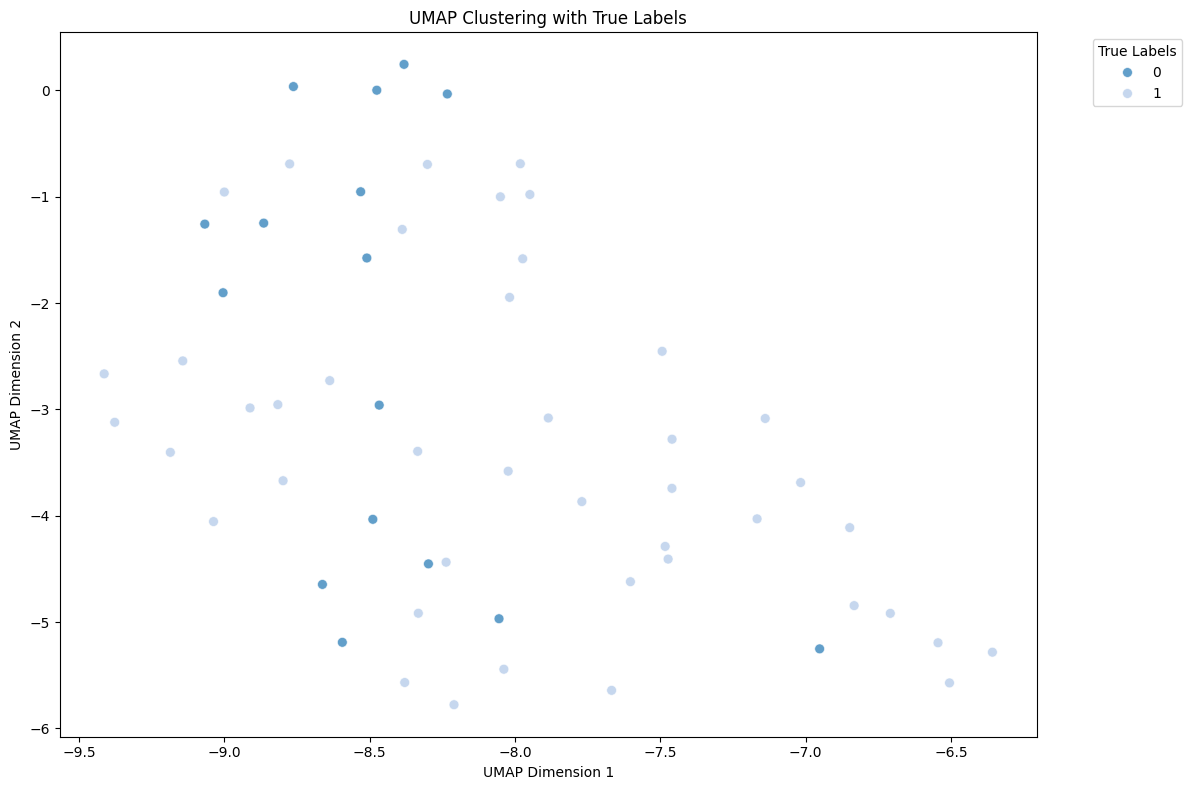

In [36]:

import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_samples, height, width = x_train.shape
x_train_reshaped = x_train.reshape(num_samples, height * width)

def visualize_umap_clustering(x_train, y_train=None, title="UMAP Clustering"):
    """
    Visualizes UMAP dimensionality reduction and HDBSCAN clustering, optionally with true labels.

    Args:
        x_train (numpy.ndarray): The training data (e.g., images).
        y_train (numpy.ndarray, optional): The true labels for the training data. Defaults to None.
        title (str, optional): The title of the plot. Defaults to "UMAP Clustering".
    """

    num_samples, height, width = x_train.shape
    x_train_reshaped = x_train.reshape(num_samples, height * width)

    # UMAP dimensionality reduction
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(x_train_reshaped)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels = clusterer.fit_predict(embedding)

    plt.figure(figsize=(12, 8))  # Increased figure size for better visibility

    # Plotting with true labels if provided
    if y_train is not None:
        unique_labels = np.unique(y_train)
        num_unique_labels = len(unique_labels)
        palette = sns.color_palette('tab20', n_colors=num_unique_labels) #using a better palette for more distinct colors.

        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_train, palette=palette, s=50, alpha=0.7)
        plt.title(f"{title} with True Labels")
        plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left') #Place legend outside the plot.

    else:
        # Plotting with HDBSCAN cluster labels
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
        plt.title(title)
        plt.legend(title="Cluster Labels", bbox_to_anchor=(1.05, 1), loc='upper left') #Place legend outside the plot.

    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.tight_layout() #Avoid label cutoffs.
    plt.show()

# Example usage (assuming x_train and y_train are defined)
visualize_umap_clustering(x_train, y_train=y_train) #with true labels
#visualize_umap_clustering(x_train) #without true labels

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


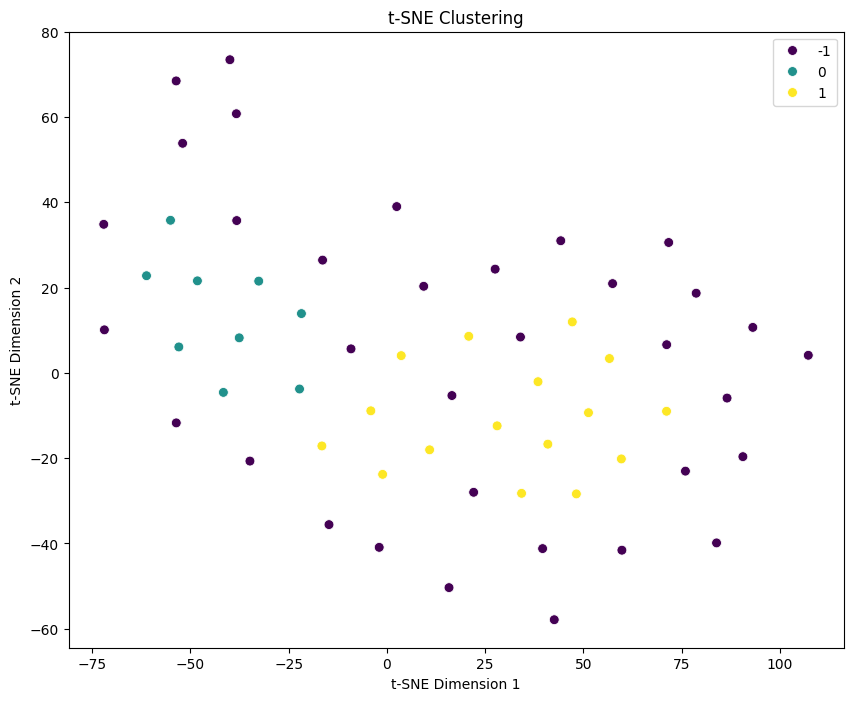

Adjusted Rand Index (ARI): -0.0061
Normalized Mutual Information (NMI): 0.0023


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def cluster_with_tsne_and_evaluate(data, true_labels, n_components=2, perplexity=30, learning_rate=200, n_iter=1000, min_cluster_size=5, random_state=42):
    """
    Performs t-SNE dimensionality reduction, clusters the embedding with HDBSCAN,
    visualizes the results, and evaluates the clustering performance using ARI and NMI.

    Args:
        data (numpy.ndarray): The high-dimensional data as a NumPy array.
        true_labels (numpy.ndarray): The true labels for the data points.
        n_components (int): The number of dimensions for the t-SNE embedding (usually 2).
        perplexity (int): The perplexity parameter for t-SNE.
        learning_rate (float): The learning rate for t-SNE.
        n_iter (int): The number of iterations for t-SNE.
        min_cluster_size (int): The minimum cluster size for HDBSCAN.
        random_state (int): Seed for reproducibility.

    Returns:
        None (displays a plot and prints evaluation metrics).
    """

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=random_state)
    embedding = tsne.fit_transform(data)

    # Cluster the t-SNE embedding using HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    predicted_labels = clusterer.fit_predict(embedding)

    # Visualize the clustered t-SNE embedding
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=predicted_labels, palette='viridis', s=50)
    plt.title("t-SNE Clustering")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

    # Evaluate clustering performance
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


# Then pass x_train_reshaped to cluster_with_tsne
cluster_with_tsne_and_evaluate(x_train_reshaped, y_train)
